#Predictive modeling of customer bookings

This project simulates a data analysis task for British Airways on the Forage platform. It explores which factors influence customer booking decisions using a dataset of customer bookings. By leveraging Jupyter Notebook and various Python libraries, the project cleans and analyses the data, then builds and visualises a Random Forest classification model to identify key drivers of customer booking behaviour.

In [ ]:
# Data Processing
import pandas as pd
import numpy as np
from numpy import mean

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Outliers
from scipy.stats import mstats
from scipy import stats

# Data Pre_processing
from sklearn.preprocessing import OneHotEncoder

# Ensembled Sampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier
from collections import Counter

# Model Building & Metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, RepeatedStratifiedKFold

In [ ]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

#Exploratory Data Analysis (EDA) & Data Preprocessing

-Data preprocessing is a critical step that prepares raw data for analysis or modelling. It addresses issues like missing values, outliers, and type inconsistencies, ultimately transforming the data into a suitable format for reliable and accurate results. It also includes encoding categorical variables, scaling features by using normalisation or standardisation. Different preprocessing steps and modelling techniques may be needed for each data type, which will be considered during the analysis.

-EDA includes understanding the data, summarising (mean, SD) for numerical variables and (frequencies, percentages) for categorical variables, visualising (boxplots, histograms, heatmaps) to explore the distribution of data, detect outliers, and relationships between variables.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

##Summary Statistics

In [ ]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
num_passengers,50000.0,NaN,NaN,NaN,1.59124,1.020165,1.0,1.0,1.0,2.0,9.0
sales_channel,50000,2,Internet,44382,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trip_type,50000,3,RoundTrip,49497,NaN,NaN,NaN,NaN,NaN,NaN,NaN
purchase_lead,50000.0,NaN,NaN,NaN,84.94048,90.451378,0.0,21.0,51.0,115.0,867.0
length_of_stay,50000.0,NaN,NaN,NaN,23.04456,33.88767,0.0,5.0,17.0,28.0,778.0
flight_hour,50000.0,NaN,NaN,NaN,9.06634,5.41266,0.0,5.0,9.0,13.0,23.0
flight_day,50000,7,Mon,8102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
route,50000,799,AKLKUL,2680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
booking_origin,50000,104,Australia,17872,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wants_extra_baggage,50000.0,NaN,NaN,NaN,0.66878,0.470657,0.0,0.0,1.0,1.0,1.0


In [ ]:
df.duplicated().sum()

719

The DataFrame contains 719 duplicates rows requiring permanent removal.

In [ ]:
df[df.duplicated(keep=False)]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
115,1,Internet,RoundTrip,65,278,2,Thu,AKLKUL,Malaysia,0,0,0,8.83,0
117,1,Internet,RoundTrip,263,58,4,Sun,AKLKUL,Malaysia,0,1,0,8.83,0
122,1,Internet,RoundTrip,42,17,14,Tue,AKLKUL,Malaysia,0,0,0,8.83,1
135,4,Internet,RoundTrip,366,17,16,Sun,AKLKUL,Malaysia,1,0,1,8.83,0
177,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49905,1,Internet,RoundTrip,2,6,3,Thu,PENTPE,Malaysia,0,0,1,4.67,0
49911,1,Internet,RoundTrip,30,6,7,Thu,PENTPE,Taiwan,0,0,0,4.67,0
49934,1,Internet,RoundTrip,2,6,3,Thu,PENTPE,Malaysia,0,0,1,4.67,0
49944,1,Internet,RoundTrip,2,6,3,Thu,PENTPE,Malaysia,0,0,1,4.67,0


In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df.duplicated().sum()

0

##Checking for null values

In [ ]:
df.isna().sum()

,0
num_passengers,0
sales_channel,0
trip_type,0
purchase_lead,0
length_of_stay,0
flight_hour,0
flight_day,0
route,0
booking_origin,0
wants_extra_baggage,0


There is no null value in the data.

##Exploring Data Distribution: Box Plots and Histograms


*   Box plot represents the distribution of a variable and displays outliers.
*   Histogram visualises the distribution of a continuous variable.



###Numerical Variables

Purchase Lead Variable

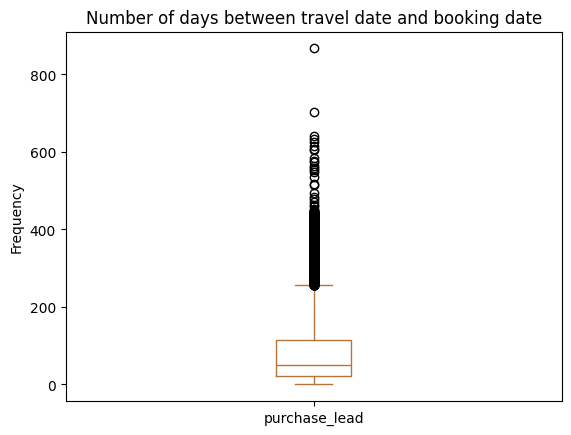

In [ ]:
df['purchase_lead'].plot(kind = 'box', color = '#b87339')
plt.title('Number of days between travel date and booking date', fontsize = 12)
plt.ylabel('Frequency', fontsize = 10)
plt.show()

There are outliers between 350 and 860 days between travel and booking date. Further investigation is required as the airlines normally do not release flights for booking more than a year in advance. The customers might not even booking a flight two years out.

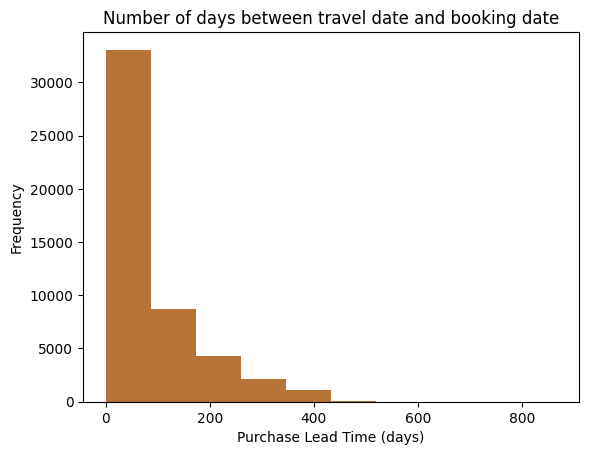

In [ ]:
df['purchase_lead'].plot(kind = 'hist', color = '#b87339')
plt.title('Number of days between travel date and booking date', fontsize = 12)
plt.xlabel('Purchase Lead Time (days)', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.show()

The distribution is positively skewed, which means that most values are clustered around the left tail.

Length of Stay Variable

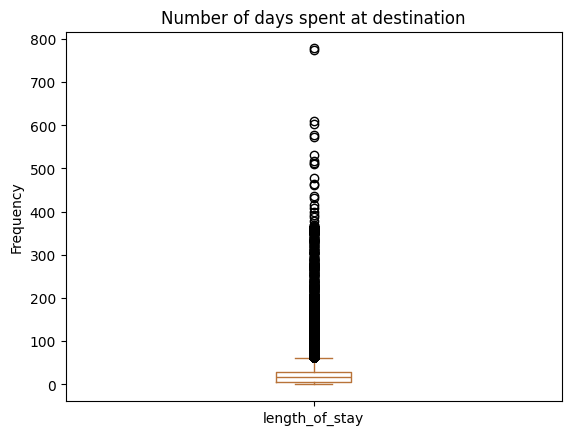

In [ ]:
df['length_of_stay'].plot(kind = 'box', color = '#b87339')
plt.title('Number of days spent at destination', fontsize = 12)
plt.ylabel('Frequency', fontsize = 10)
plt.show()

Outliers detected between 60 and 778 require further investigation.

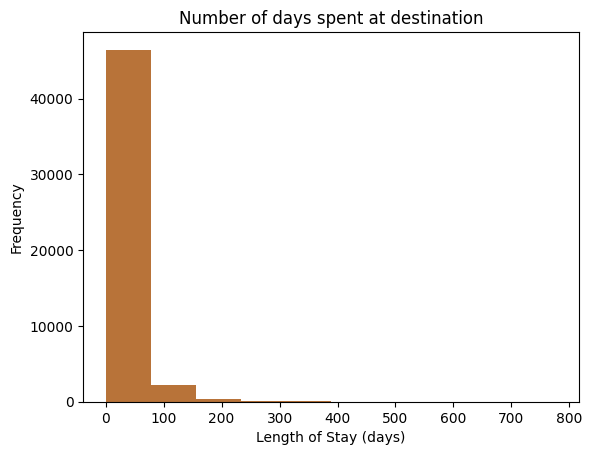

In [ ]:
df['length_of_stay'].plot(kind = 'hist', color = '#b87339')
plt.title('Number of days spent at destination', fontsize = 12)
plt.xlabel('Length of Stay (days)', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.show()

A positive skew was observed in the distribution of the variable, which deviates from normality. This means, most data are concentrated on the left side of the distribution.

Flight Hour Variable

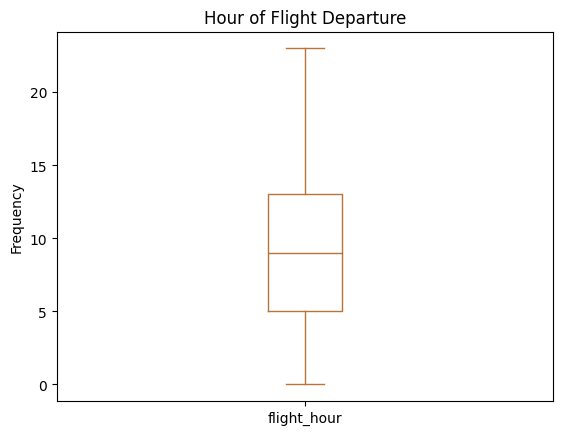

In [ ]:
df['flight_hour'].plot(kind = 'box', color = '#b87339')
plt.title('Hour of Flight Departure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 10)
plt.show()

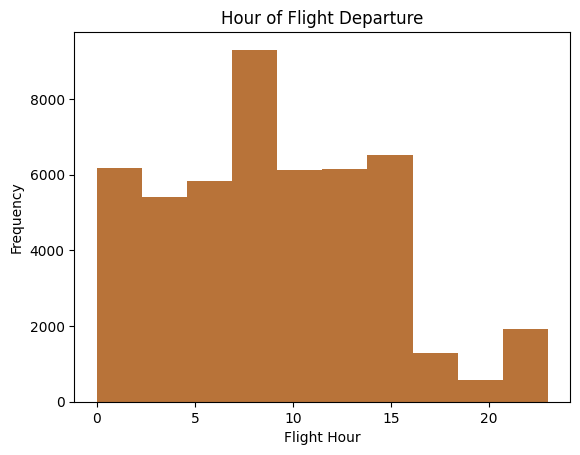

In [ ]:
df['flight_hour'].plot(kind = 'hist', color = '#b87339')
plt.title('Hour of Flight Departure', fontsize = 12)
plt.xlabel('Flight Hour', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.show()

The data is not normally distributed. There are no outliers present. Most flights depart in the morning, with an average departure time of 9am.

Flight Duration Variable

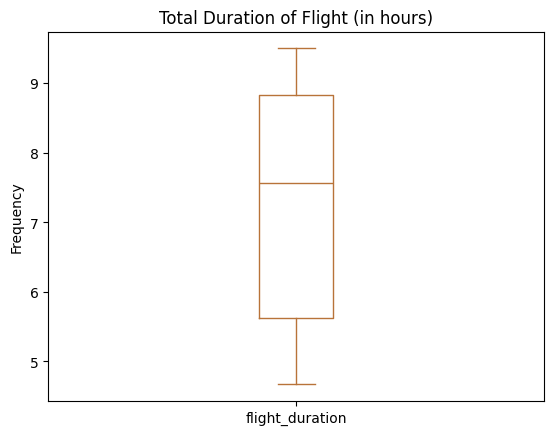

In [ ]:
df['flight_duration'].plot(kind = 'box', color = '#b87339')
plt.title('Total Duration of Flight (in hours)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 10)
plt.show()

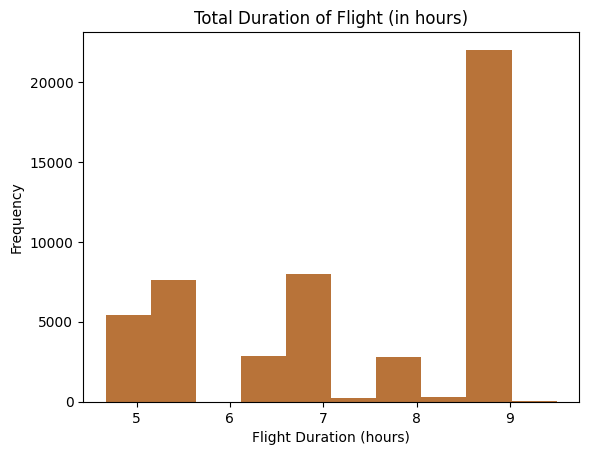

In [ ]:
df['flight_duration'].plot(kind = 'hist', color = '#b87339')
plt.title('Total Duration of Flight (in hours)', fontsize = 12)
plt.xlabel('Flight Duration (hours)', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.show()

The plot shows that the data does not follow a normal distribution. However, there are no outliers. 9 hours is the most popular flight duration based on flight data.

**Outlier Analysis**

The features such as 'purchase_lead' and 'length of stay' have z-scores exceeding 3, indicating they are significantly different from the average values in the dataset. The boxplot reveales a non-normal distribution with extreme values that may not represent the typical population.

Since the distribution is right-skewed, winsorising might be a good option. This is because winsorising replaces extreme values at the upper tail of the distribution with values closer to the rest of the data. This approach retains some information about the tail while reducing the influence of extreme outliers.

Transformed purchase lead variable

In [ ]:
z_scores = stats.zscore(df['purchase_lead'])

In [ ]:
outliers = df[(z_scores > 3)|(z_scores <-3)]

In [ ]:
df['purchase_lead_winsorized'] = mstats.winsorize(df['purchase_lead'], limits = [0.01, 0.01])

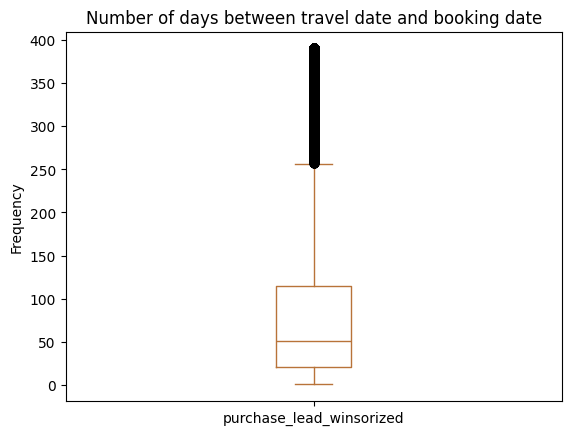

In [ ]:
df['purchase_lead_winsorized'].plot(kind = 'box', color = '#b87339')
plt.title('Number of days between travel date and booking date', fontsize = 12)
plt.ylabel('Frequency', fontsize = 10)
plt.show()

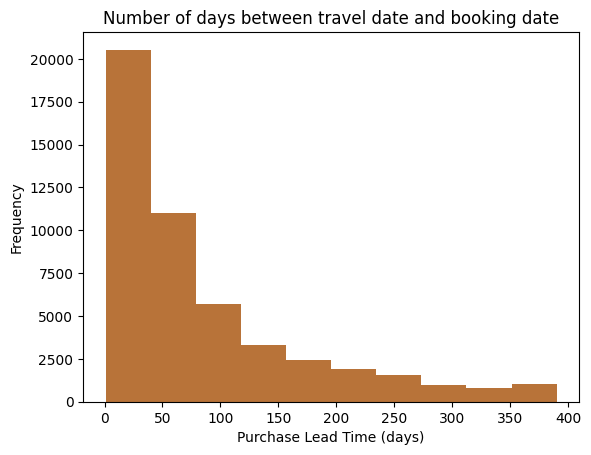

In [ ]:
df['purchase_lead_winsorized'].plot(kind = 'hist', color = '#b87339')
plt.title('Number of days between travel date and booking date', fontsize = 12)
plt.xlabel('Purchase Lead Time (days)', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.show()

Transformed length of stay variable

In [ ]:
z_scores = stats.zscore(df['length_of_stay'])

In [ ]:
outliers = df[(z_scores > 3)|(z_scores <-3)]

In [ ]:
df['length_of_stay_winsorized'] = mstats.winsorize(df['length_of_stay'], limits = [0.01, 0.01])

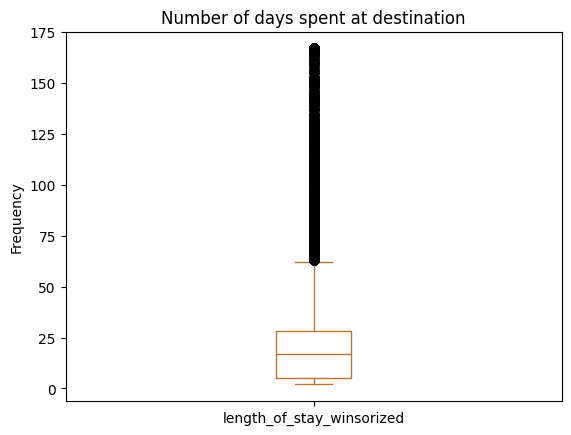

In [ ]:
df['length_of_stay_winsorized'].plot(kind = 'box', color = '#b87339')
plt.title('Number of days spent at destination', fontsize = 12)
plt.ylabel('Frequency', fontsize = 10)
plt.show()

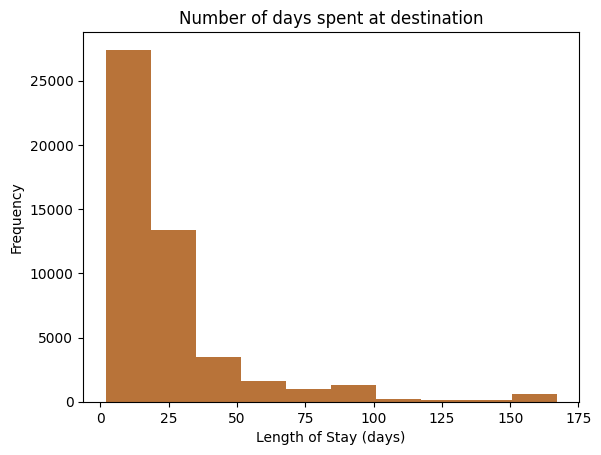

In [ ]:
df['length_of_stay_winsorized'].plot(kind = 'hist', color = '#b87339')
plt.title('Number of days spent at destination', fontsize = 12)
plt.xlabel('Length of Stay (days)', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.show()

Unprocessed Purchase Lead Variables vs Booking Completion

<ipython-input-28-879fe989b4d7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot( x = 'booking_complete', y = 'purchase_lead', data = df, palette = 'pastel')


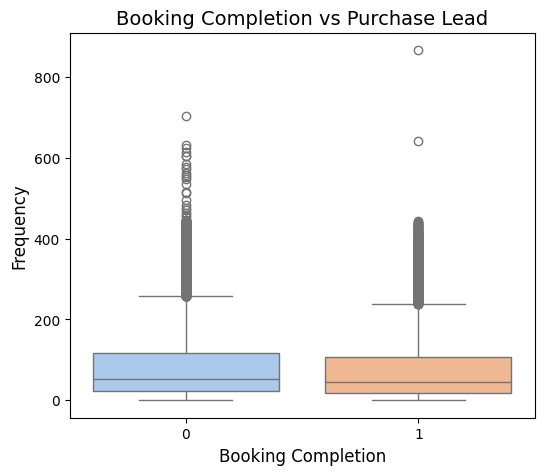

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot( x = 'booking_complete', y = 'purchase_lead', data = df, palette = 'pastel')
plt.title('Booking Completion vs Purchase Lead', fontsize = 14)
plt.xlabel('Booking Completion', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.show()

Transformed Purchase Lead Variable vs Booking Completion

<ipython-input-29-db01748d9e79>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot( x = 'booking_complete', y = 'purchase_lead_winsorized', data = df, palette = 'pastel')


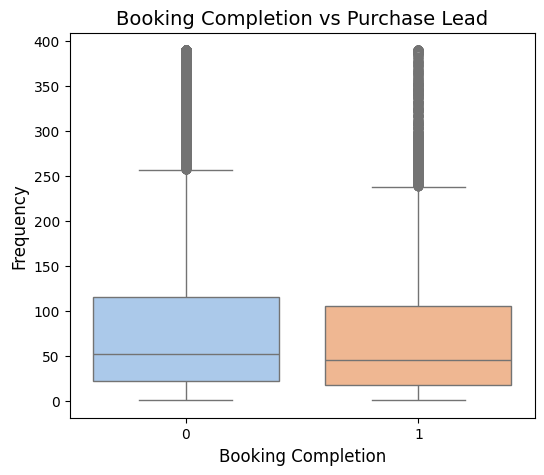

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot( x = 'booking_complete', y = 'purchase_lead_winsorized', data = df, palette = 'pastel')
plt.title('Booking Completion vs Purchase Lead', fontsize = 14)
plt.xlabel('Booking Completion', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.show()

Unprocessed Length of Stay vs Booking Completion

<ipython-input-30-a888861ec0de>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot( x = 'booking_complete', y = 'length_of_stay', data = df, palette = 'pastel')


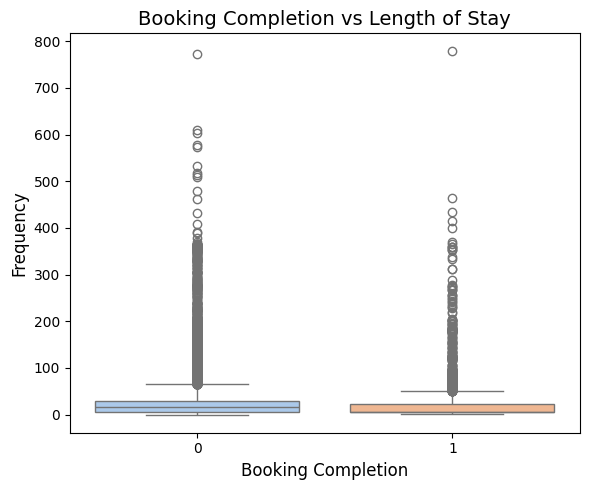

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot( x = 'booking_complete', y = 'length_of_stay', data = df, palette = 'pastel')
plt.title('Booking Completion vs Length of Stay', fontsize = 14)
plt.xlabel('Booking Completion', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.tight_layout()
plt.show()

Transformed Length of Stay Variables vs Booking Completion

<ipython-input-31-7c8cd017c02e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot( x = 'booking_complete', y = 'length_of_stay_winsorized', data = df, palette = 'pastel')


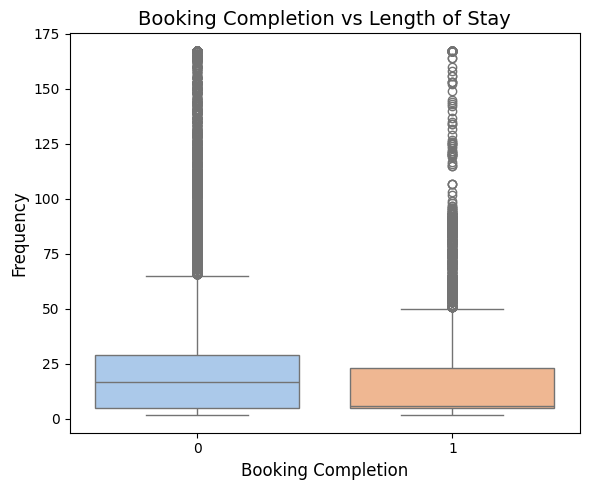

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot( x = 'booking_complete', y = 'length_of_stay_winsorized', data = df, palette = 'pastel')
plt.title('Booking Completion vs Length of Stay', fontsize = 14)
plt.xlabel('Booking Completion', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.tight_layout()
plt.show()

###Categorical Variables

Nominal data describes categories without inherent order (like shirt colours). Because ML models work with numbers, these categories need to be convert into numerical format suitable for analysis. Thus, One Hot Encoder will be used for data preprocessing.

Sales Channel Variable

In [ ]:
df['sales_channel'].value_counts()

,count
sales_channel,
Internet,43917
Mobile,5364


<ipython-input-35-c05b4d6001f5>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plots = ax[1] = sns.countplot(x = 'sales_channel', data = df, palette = 'pastel')


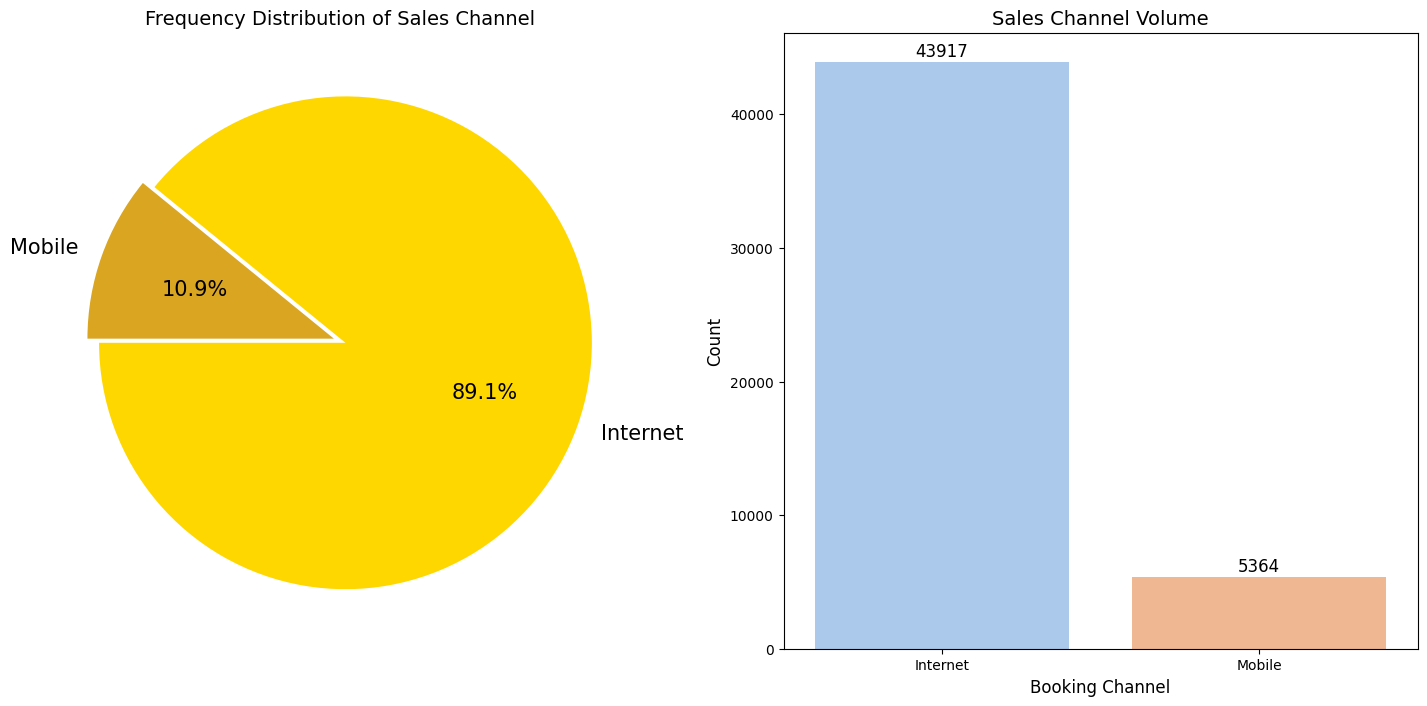

In [ ]:
#Visualising frequency distribution of 'sales_channel' variable

f,ax=plt.subplots(1,2,figsize=(18,8))
ax[0] = df['sales_channel'].value_counts().plot.pie(explode=[0.025, 0.025], autopct='%1.1f%%', ax=ax[0], colors = ['#ffd700', '#daa520'], startangle = 180, textprops = {'fontsize': 15})
ax[0].set_title('Frequency Distribution of Sales Channel', fontsize = 14)
ax[0].set_ylabel(' ')

plots = ax[1] = sns.countplot(x = 'sales_channel', data = df, palette = 'pastel')
ax[1].set_title('Sales Channel Volume', fontsize = 14)
ax[1].set_xlabel('Booking Channel', fontsize = 12)
ax[1].set_ylabel('Count', fontsize = 12)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',size=12,
                   xytext=(0, 8),
                   textcoords='offset points')
plt.show()

The data visualisation revealed a clear dominance of the Internet channel for sales. Among 49281 sales, a substantial 43917 (almost 90%) were made online, while mobile bookings accounted for only 5364 (around 11%). This significant imbalance in sales distribution suggests that the 'sales channel' variable might have limited predictive power in our model due to the lack of variation.

In [ ]:
#Encoding

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False). set_output(transform = 'pandas')
ohetransform = ohe.fit_transform(df[['sales_channel']])
df = pd.concat([df, ohetransform], axis = 1)

Trip Type Variable

In [ ]:
df['trip_type'].value_counts()

,count
trip_type,
RoundTrip,48779
OneWay,386
CircleTrip,116


<ipython-input-38-ac2de02074d4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plots = sns.countplot(x = 'trip_type', data = df, palette = 'pastel')


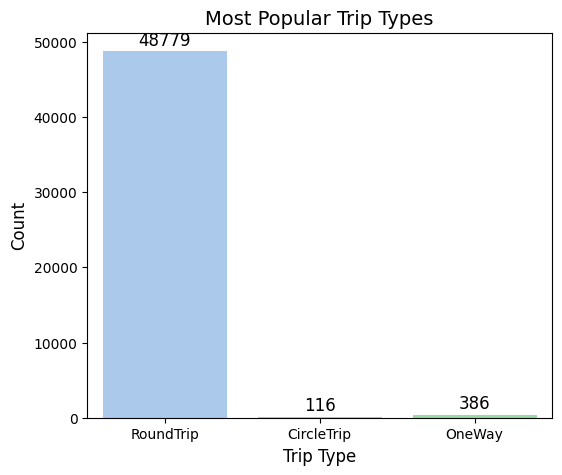

In [ ]:
#Visualising frequency distribution of 'sales_channel' variable

plt.figure(figsize = (6, 5))
plots = sns.countplot(x = 'trip_type', data = df, palette = 'pastel')
plt.title('Most Popular Trip Types', fontsize = 14)
plt.xlabel('Trip Type', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='center',size=12,
                   xytext=(0, 8),
                   textcoords='offset points')

The most popular trip type leans heavily towards round trips, with a clear dominance of 48779 bookings compared to 386 one-way trips and 116 circle trips. This unbalanced distribution suggests that the variable might have limited predictive power in our model. Since round trips are the overwhelming choice, it may not provide enough variation to significantly influence our predictions.

In [ ]:
ohe1 = OneHotEncoder(handle_unknown='ignore', sparse_output=False). set_output(transform = 'pandas')
ohetransform1 = ohe1.fit_transform(df[['trip_type']])
df = pd.concat([df, ohetransform1], axis = 1)

Flight Hour Variable

In [ ]:
df['flight_hour'].value_counts()

,count
flight_hour,
8,3125
12,3114
9,3097
7,3080
11,3071
10,3050
13,3046
6,3010
5,2817


In [ ]:
def categorize_item(x):
  if 0 <= x < 6:
    return 'Night'
  elif 6 <= x < 12:
    return 'Morning'
  elif 12 <= x < 18:
    return 'Afternoon'
  else:
    return 'Evening'

df['flight_hour_categ']=df['flight_hour'].apply(categorize_item)

In [ ]:
ohe2 = OneHotEncoder(handle_unknown='ignore', sparse_output=False). set_output(transform = 'pandas')
ohetransform2 = ohe2.fit_transform(df[['flight_hour_categ']])
df = pd.concat([df, ohetransform2], axis = 1)

Flight Day Variable

In [ ]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

<ipython-input-44-fbcd2e8bf2c0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plots = sns.countplot(x = 'flight_day', data = df, palette = 'pastel')


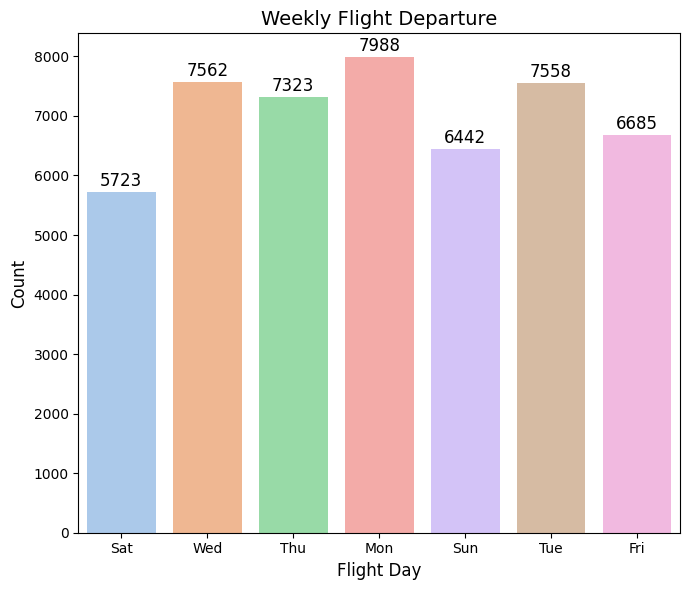

In [ ]:
plt.figure(figsize = (7, 6))
plots = sns.countplot(x = 'flight_day', data = df, palette = 'pastel')

plt.title('Weekly Flight Departure', fontsize = 14)
plt.xlabel('Flight Day', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.tight_layout()

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
     (bar.get_x() + bar.get_width() / 2, bar.get_height()),
      ha='center', va='center',size=12, xytext=(0, 8), textcoords='offset points')

In [ ]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [ ]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

Route Variable¶

The route variable was split into departures and arrivals, which contain airport codes. Continent linking is possible, but the variable itself has low impact on the model. Hence, it can be removed from the model.

In [ ]:
df['departures'] = df['route'].str[:3]
df['arrivals'] = df['route'].str[-3:]

In [ ]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,...,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip,flight_hour_categ,flight_hour_categ_Afternoon,flight_hour_categ_Evening,flight_hour_categ_Morning,flight_hour_categ_Night,departures,arrivals
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,...,0.0,0.0,1.0,Morning,0.0,0.0,1.0,0.0,AKL,DEL
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,...,0.0,0.0,1.0,Night,0.0,0.0,0.0,1.0,AKL,DEL
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,...,0.0,0.0,1.0,Afternoon,1.0,0.0,0.0,0.0,AKL,DEL
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,...,0.0,0.0,1.0,Night,0.0,0.0,0.0,1.0,AKL,DEL
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,...,0.0,0.0,1.0,Afternoon,1.0,0.0,0.0,0.0,AKL,DEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,...,0.0,0.0,1.0,Morning,0.0,0.0,1.0,0.0,PER,PNH
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,...,0.0,0.0,1.0,Night,0.0,0.0,0.0,1.0,PER,PNH
49997,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,...,0.0,0.0,1.0,Evening,0.0,1.0,0.0,0.0,PER,PNH
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,...,0.0,0.0,1.0,Morning,0.0,0.0,1.0,0.0,PER,PNH


Booking Origin Variables

In [ ]:
df['booking_origin'].value_counts()

,count
booking_origin,
Australia,17691
Malaysia,7055
South Korea,4502
Japan,3819
China,3284
...,...
Panama,1
Tonga,1
Tanzania,1


<ipython-input-50-4ca4bc6f9072>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plots = sns.countplot(x = 'booking_origin', data = booking_origin_top10, palette = 'pastel', order = top10.index)


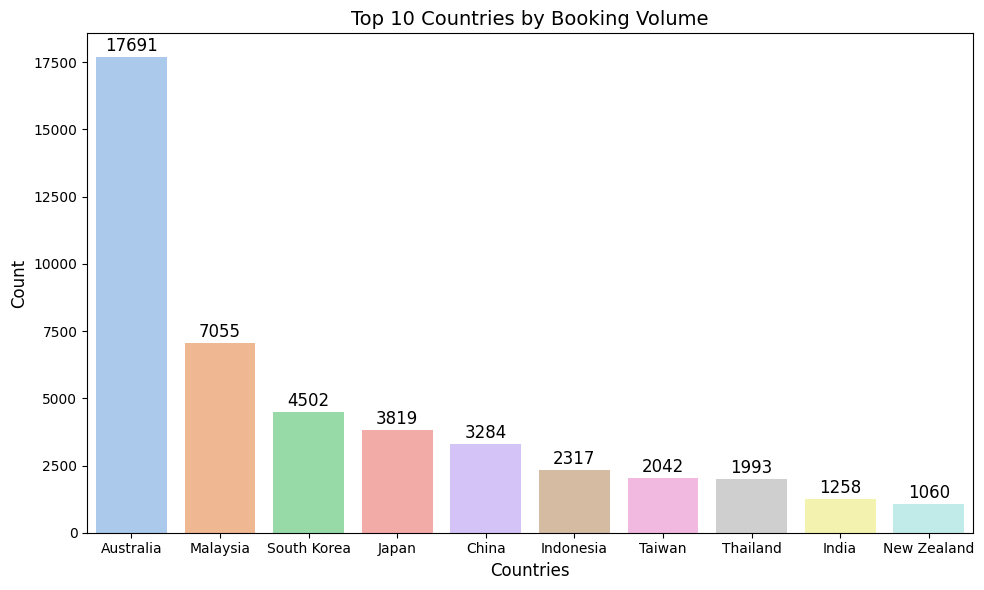

In [ ]:
top10 = df['booking_origin'].value_counts().sort_values(ascending = False).head(10)
booking_origin_top10 = df[df['booking_origin'].isin(top10.index)]
plt.figure(figsize = (10, 6))
plots = sns.countplot(x = 'booking_origin', data = booking_origin_top10, palette = 'pastel', order = top10.index)
plt.title('Top 10 Countries by Booking Volume', fontsize = 14)
plt.xlabel('Countries', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.tight_layout()

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
     (bar.get_x() + bar.get_width() / 2, bar.get_height()),
      ha='center', va='center',size=12, xytext=(0,8), textcoords='offset points')

plt.show()

According to the plot, Australia is the top country from where booking was made, followed by Malaysia and South Korea. It appears that Australia might be an important feature in our prediction model.

Booking Continent Variable

In [ ]:
continents = {'Australia': 'Oceania','Malaysia': 'Asia','South Korea': 'Asia','Japan': 'Asia','China': 'Asia','Indonesia': 'Asia','Taiwan': 'Asia','Thailand': 'Asia',
              'India': 'Asia','New Zealand': 'Oceania','Singapore': 'Asia','United States': 'North America','Vietnam': 'Asia','Macau': 'Asia','Hong Kong': 'Asia',
              'Philippines': 'Asia','United Kingdom': 'Europe','Brunei': 'Asia','Cambodia': 'Asia','(not set)': 'Unknown','Sri Lanka': 'Asia','Italy': 'Europe',
              'France': 'Europe', 'Canada': 'North America', 'Germany': 'Europe', 'Myanmar (Burma)': 'Asia', 'Netherlands': 'Europe', 'Mauritius': 'Africa',
              'United Arab Emirates': 'Asia','Nepal': 'Asia','Bangladesh': 'Asia','Saudi Arabia': 'Asia','Russia': 'Europe','Spain': 'Europe','Laos': 'Asia',
              'Switzerland': 'Europe','Chile': 'South America','Qatar': 'Asia','Iran': 'Asia','Sweden': 'Europe','Réunion': 'Africa','Mexico': 'South America',
              'Kuwait': 'Asia','Oman': 'Asia','Brazil': 'South America','Turkey': 'Asia','Mongolia': 'Asia','Austria': 'Europe','Poland': 'Europe',
              'Czech Republic': 'Europe','Finland': 'Europe','Ireland': 'Europe','Maldives': 'Asia','Denmark': 'Europe','Belgium': 'Europe','Greece': 'Europe',
              'Argentina': 'South America','New Caledonia': 'Oceania','Portugal': 'Europe','Ukraine': 'Europe','Norway': 'Europe','Bahrain': 'Asia','Peru': 'South America',
              'Colombia': 'South America','Romania': 'Europe','South Africa': 'Africa','Kenya': 'Africa','Kazakhstan': 'Asia','Hungary': 'Europe',
              'Israel': 'Asia','Slovenia': 'Europe','Solomon Islands': 'Oceania','Guam': 'Oceania','Timor-Leste': 'Asia','Cyprus': 'Europe','Croatia': 'Europe',
              'Tunisia': 'Africa','Vanuatu': 'Oceania','Czechia': 'Europe','Malta': 'Europe','Gibraltar': 'Europe','Belarus': 'Europe','Pakistan': 'Asia',
              'Iraq': 'Asia','Ghana': 'Africa','Seychelles': 'Africa','Guatemala': 'North America','Algeria': 'Africa','Afghanistan': 'Asia','Lebanon': 'Asia',
              'Estonia': 'Europe','Paraguay': 'South America','Papua New Guinea': 'Oceania','Jordan': 'Asia','Egypt': 'Africa','Nicaragua': 'North America',
              'Slovakia': 'Europe','Norfolk Island': 'Oceania','Bhutan': 'Asia','Panama': 'North America','Tonga': 'Oceania',
              'Tanzania': 'Africa','Bulgaria': 'Europe','Svalbard & Jan Mayen': 'Europe'}
df['booking_continent'] = df['booking_origin'].map(continents)

In [ ]:
ohe2 = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).set_output(transform = 'pandas')
ohetransform = ohe2.fit_transform(df[['booking_continent']])
#df = pd.concat([df, ohetransform], axis = 1).drop(columns = ['booking_continent'])
df = pd.concat([df, ohetransform], axis = 1)

In [ ]:
df['booking_continent'].unique()

array(['Oceania', 'Asia', 'Europe', 'Africa', 'Unknown', 'North America',
       'South America'], dtype=object)

<ipython-input-54-5302eb3c55a3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plots = sns.countplot(data=booking_origin_top4, x='booking_continent', palette='pastel', order=top4.index)


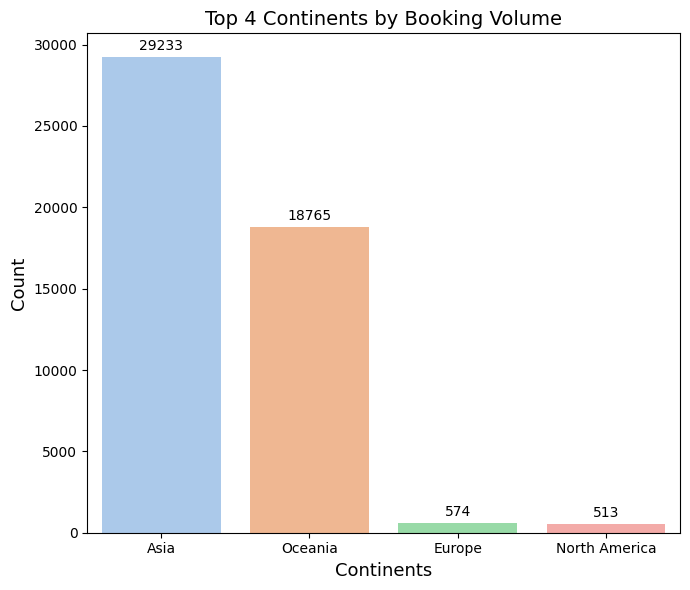

In [ ]:
#top4 = df['booking_continent'].value_counts(ascending=False).head(4)
top4 = df['booking_continent'].value_counts().sort_values(ascending=False).head(4)
booking_origin_top4 = df[df['booking_continent'].isin(top4.index)]
plt.figure(figsize=(7, 6))
plots = sns.countplot(data=booking_origin_top4, x='booking_continent', palette='pastel', order=top4.index)
plt.title('Top 4 Continents by Booking Volume', fontsize = 14)
plt.xlabel('Continents', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.tight_layout()

for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()

Dependent Variable : Booking Complete

In [ ]:
df['booking_complete'].value_counts()

,count
booking_complete,
0,41890
1,7391


<ipython-input-56-d2084d66d764>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plots = ax[1] = sns.countplot(x = 'booking_complete', data = df, palette = 'pastel')


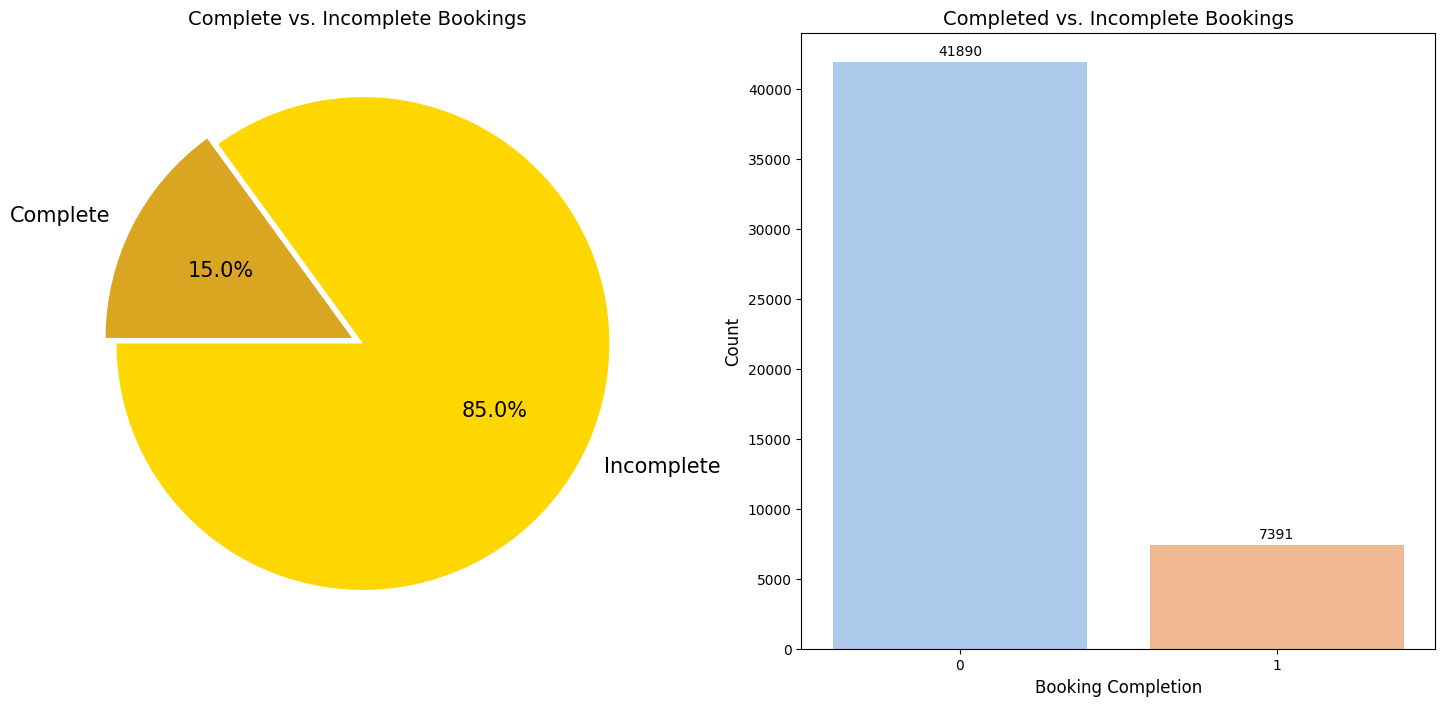

In [ ]:
labels = ['Incomplete', 'Complete']
f, ax = plt.subplots(1, 2, figsize = (18, 8))
ax[0] = df['booking_complete'].value_counts().plot.pie(explode = [0.025, 0.025],
autopct = '%1.1f%%', ax = ax[0], colors = ['#ffd700', '#daa520'], startangle = 180, textprops = {'fontsize': 15}, labels = labels)
ax[0].set_title('Complete vs. Incomplete Bookings', fontsize = 14)
ax[0].set_ylabel(' ')

plots = ax[1] = sns.countplot(x = 'booking_complete', data = df, palette = 'pastel')
ax[1].set_title('Completed vs. Incomplete Bookings', fontsize = 14)
plt.xlabel('Booking Completion', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',size=10,
                   xytext=(0, 8),
                   textcoords='offset points')
plt.show()

It is evident from the above plots that there is a high imbalance in the dataset as only 15% of customers finalised bookings for British Airways, while 85% did not. Class imbalance is a well-known challenge in machine learning. If left unaddressed, it can significantly impact model performance.

In [ ]:
df['booking_complete_str']= df['booking_complete'].astype(str)

Booking Completion vs. Flight Day

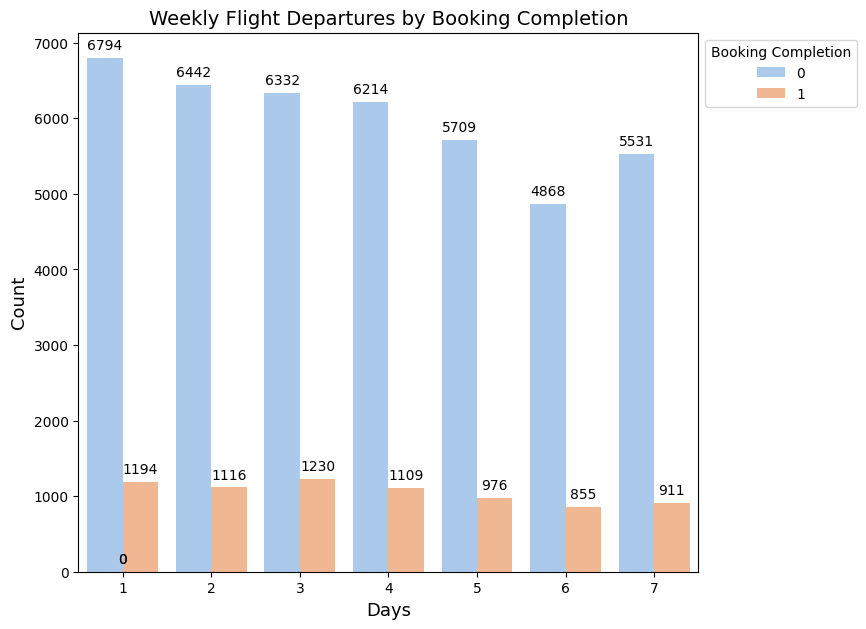

In [ ]:
plt.figure(figsize=(8,7))
splot = sns.countplot(data = df, x = 'flight_day', hue = 'booking_complete_str', palette = 'pastel')
plt.title('Weekly Flight Departures by Booking Completion', fontsize = 14)
plt.xlabel('Days', size = 13)
plt.ylabel('Count', size = 13)
plt.legend(title = 'Booking Completion', bbox_to_anchor=(1, 1), loc='upper left')
for p in splot.patches:
    splot.annotate(format(round(p.get_height())),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

plt.show()

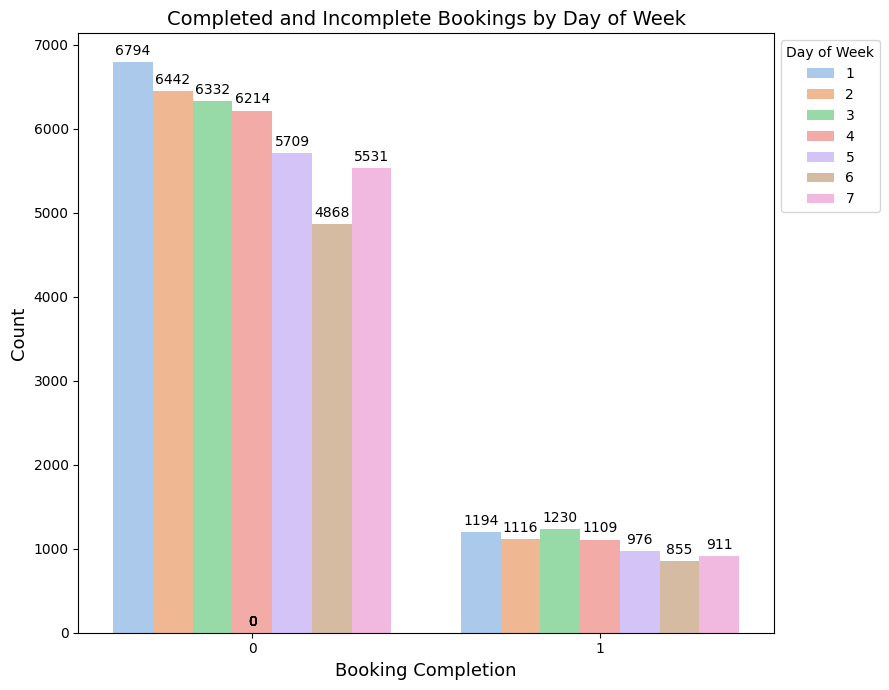

In [ ]:
plt.figure(figsize=(9, 7))
plots = sns.countplot(data=df, x='booking_complete', hue ='flight_day', palette="pastel");
plt.title('Completed and Incomplete Bookings by Day of Week', fontsize = 14)
plt.xlabel('Booking Completion', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.legend(title="Day of Week", bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()

Completed bookings peak on Wednesdays and Mondays, suggesting a preference for weekday travel over Saturdays. This trend aligns with business and leisure travel patterns, which are typically less common on weekends. In contrast, incomplete bookings are most frequent at the beginning of the week, with Mondays seeing the highest number, followed by Tuesdays and Wednesdays. Saturdays see the fewest incomplete bookings overall.

Booking Completion vs Sales Channel

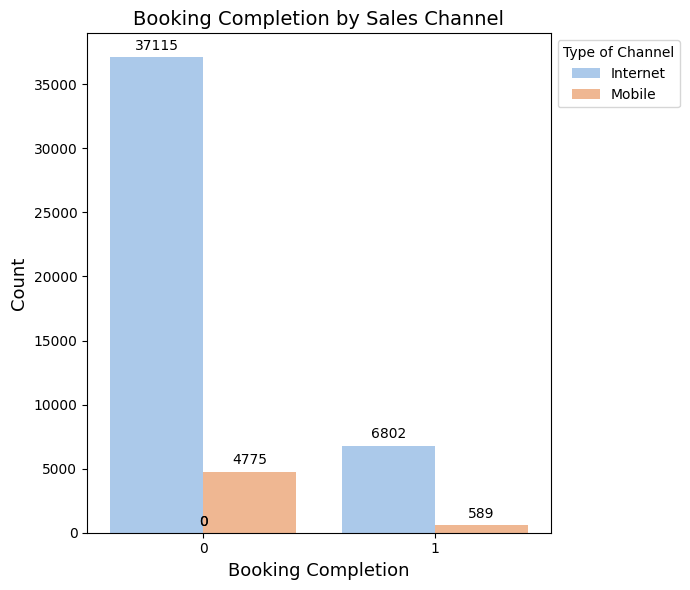

In [ ]:
plt.figure(figsize=(7, 6))
plots = sns.countplot(data=df, x='booking_complete', hue ='sales_channel', palette="pastel");
plt.title('Booking Completion by Sales Channel', fontsize = 14)
plt.xlabel('Booking Completion', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.legend(title="Type of Channel", bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()


The internet playes a prominent role in both completed bookings and those not finanlised.

In [ ]:
total = len(df['sales_channel'])
internet0 = round((len(df[(df['sales_channel'] == 'Internet') & (df['booking_complete'] == 0)])/total)*100, 1)
internet1 = round((len(df[(df['sales_channel'] == 'Internet') & (df['booking_complete'] == 1)])/total)*100, 1)
mobile0 = round((len(df[(df['sales_channel'] == 'Mobile') & (df['booking_complete'] == 0)])/total)*100, 1)
mobile1 = round((len(df[(df['sales_channel'] == 'Mobile') & (df['booking_complete'] == 1)])/total)*100, 1)
print(f'Incomplete bookings on Internet: {internet0}' '%')
print(f'Incomplete bookings on mobile: {mobile0}' '%')
print(f'Completed bookings on Internet: {internet1}' '%')
print(f'Completed bookings on mobile: {mobile1}' '%')

Incomplete bookings on Internet: 75.3%
Incomplete bookings on mobile: 9.7%
Completed bookings on Internet: 13.8%
Completed bookings on mobile: 1.2%


In [ ]:
percentage = [internet0, mobile0, internet1, mobile1]
percentage

[75.3, 9.7, 13.8, 1.2]

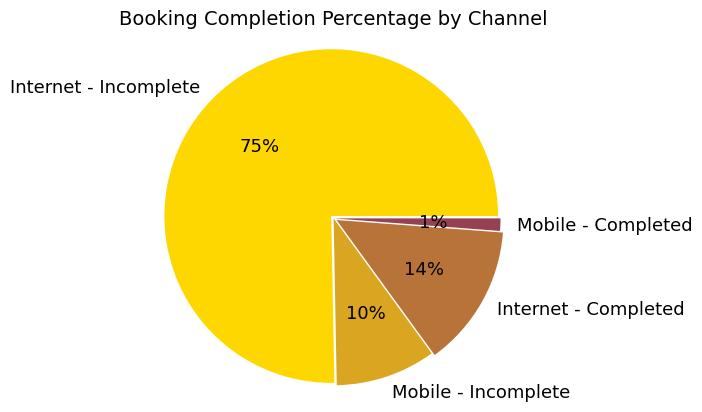

In [ ]:
categories = ['Internet - Incomplete', 'Mobile - Incomplete', 'Internet - Completed', 'Mobile - Completed']
colours = ['#ffd700', '#daa520', '#b87339', '#964152']
plt.pie(percentage, labels = categories, autopct = '%1.0f%%', colors = colours, textprops = {'fontsize': 13}, explode = (0.020, 0, 0.020, 0));
plt.title('Booking Completion Percentage by Channel', fontsize = 14)
plt.axis('equal');

For booking completions, the internet was dominant, with 14% success compared to just 1% for mobile. When looking at non-completed bookings, 75% of customers who did not finalise used the internet, followed by 10% attempting via mobile.

Booking Completion vs Trip Type

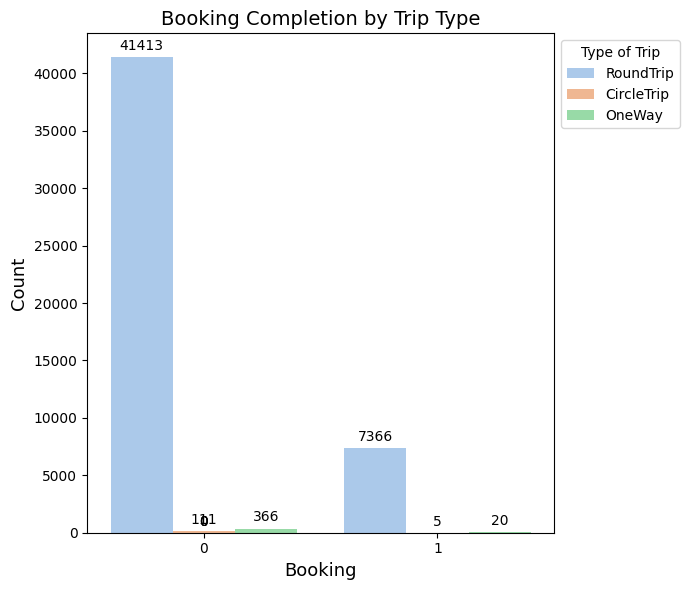

In [ ]:
plt.figure(figsize=(7, 6))
plots = sns.countplot(data=df, x='booking_complete', hue='trip_type', palette='pastel');
plt.title('Booking Completion by Trip Type', fontsize = 14)
plt.xlabel('Booking', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.legend(title='Type of Trip', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()

Round trip bookings emerged as the clear favourite among customers who finalised their bookings, with a total of 7366. As the most common travel booking type, round trip itineraries are ideal for journeys where you return to your starting point.

Booking Completion vs. Flight Hour Categorisation

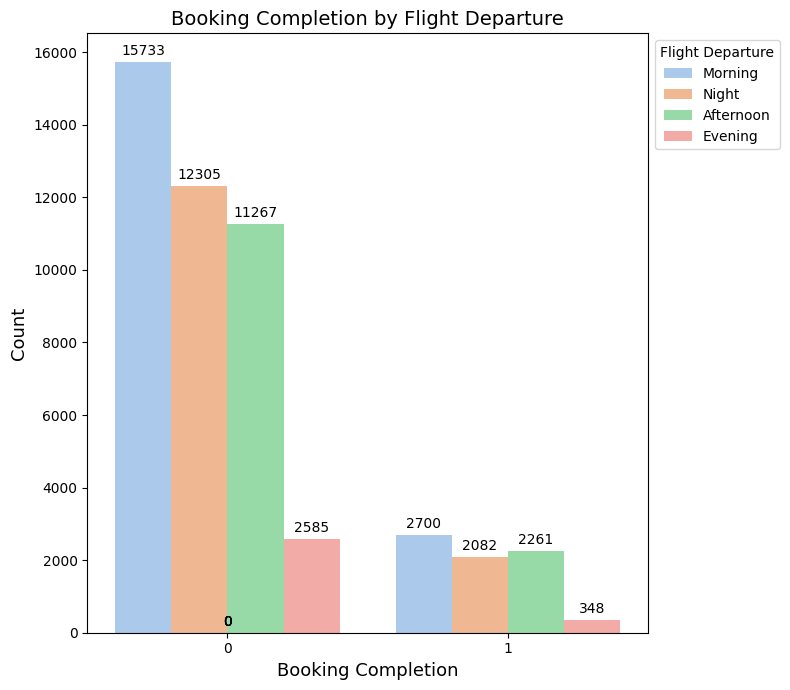

In [ ]:
plt.figure(figsize=(8,7))
plots = sns.countplot(data = df, x = 'booking_complete', hue = 'flight_hour_categ', palette = 'pastel');
plt.title('Booking Completion by Flight Departure', fontsize = 14)
plt.xlabel('Booking Completion', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.legend(title = 'Flight Departure', bbox_to_anchor = (1, 1), loc ='upper left')
plt.tight_layout()
for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()

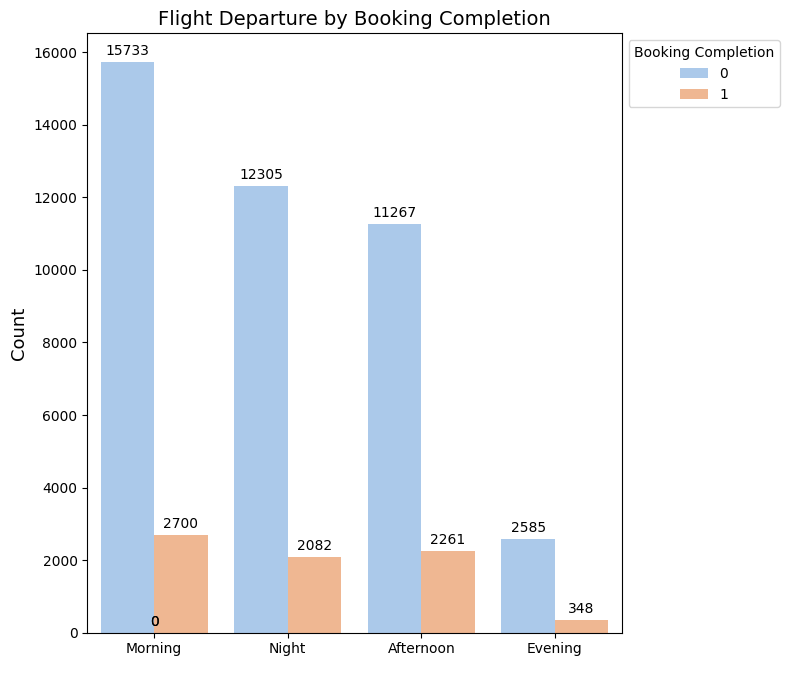

In [ ]:
plt.figure(figsize=(8,7))
plots = sns.countplot(data = df, x = 'flight_hour_categ', hue = 'booking_complete_str', palette = 'pastel'); # palette = 'deep'
plt.title('Flight Departure by Booking Completion', fontsize = 14)
plt.xlabel(' ', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.legend(title = 'Booking Completion', bbox_to_anchor = (1, 1), loc ='upper left')
plt.tight_layout()
for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()

linkcode
Booking activity (completed and incomplete) peaks in the mornings and dips in the evenings.

Booking Completion vs. Flight Hour

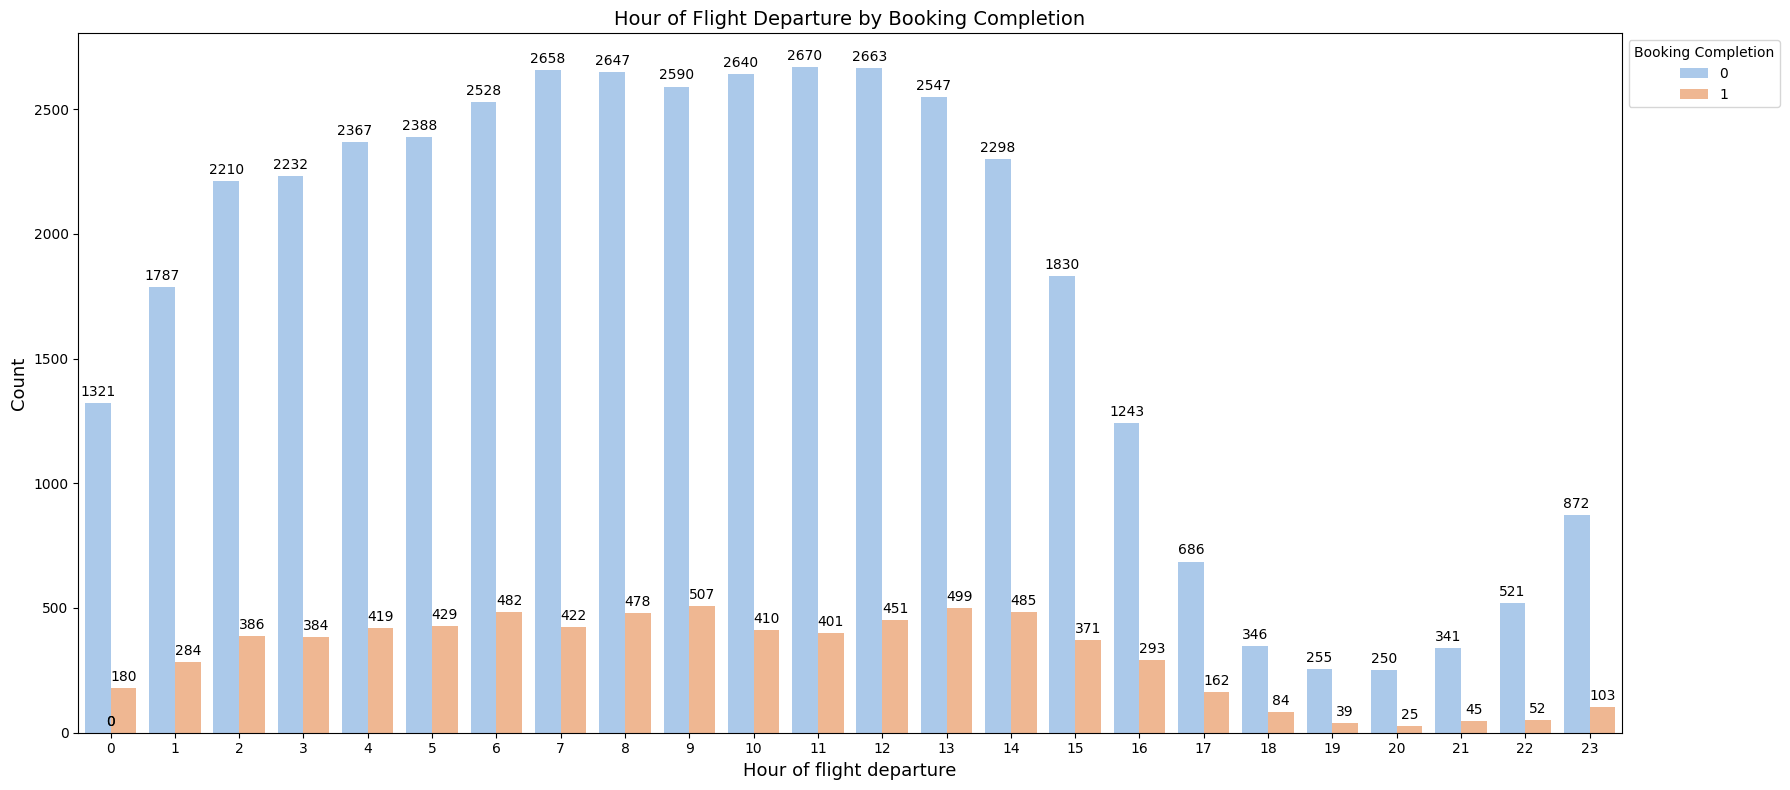

In [ ]:
plt.figure(figsize=(18,8))
plots = sns.countplot(data = df, x = 'flight_hour', hue = 'booking_complete_str', palette = 'pastel'); # palette = 'deep'
plt.title('Hour of Flight Departure by Booking Completion', fontsize = 14)
plt.xlabel('Hour of flight departure', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.legend(title = 'Booking Completion', bbox_to_anchor = (1, 1), loc ='upper left')
plt.tight_layout()
for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()

The chart reveals patterns for completed and incomplete flight departures. Completed bookings peak at 9 am. Interestingly, there's a secondary rise around 1 pm before a steady decline towards 8 pm. After 8 pm, it increases again.

In contrast, incomplete bookings peak at 11 am and generally decrease throughout the day, with an increase after 8 pm.

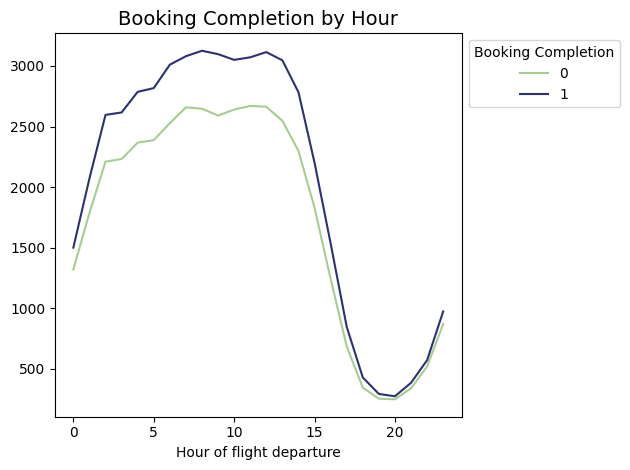

In [ ]:
df.groupby(['flight_hour', 'booking_complete']).size().unstack().plot(kind='line', colormap='crest', stacked=True);
plt.title('Booking Completion by Hour', fontsize = 14)
plt.xlabel('Hour of flight departure')
plt.legend(title = 'Booking Completion', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

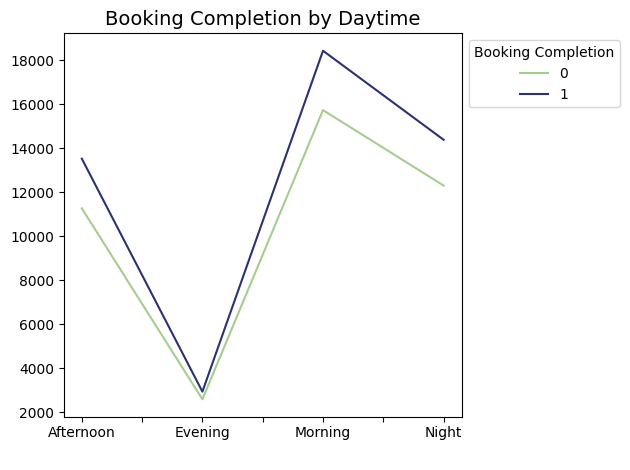

In [ ]:
df.groupby(['flight_hour_categ', 'booking_complete']).size().unstack().plot(kind='line', colormap='crest', stacked=True);
plt.title('Booking Completion by Daytime', fontsize = 14)
plt.xlabel(' ')
plt.legend(title='Booking Completion', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The chart analyses booking completions for flights categorised by departure time such as morning, afternoon, evening, and night. Interestingly, customers who finalised bookings skewed towards morning departures compared to evenings. This suggests that departure time plays a role in completion rates.

While the trend is similar for incomplete bookings generally decreasing throughout the day, the difference between completed and incomplete bookings is less pronounced for evening departures.

In other words, morning flights tend to have a higher completion rate compared to evenings. However, the total number of evening bookings might still be significant.

Booking Completion vs. Flight Duration

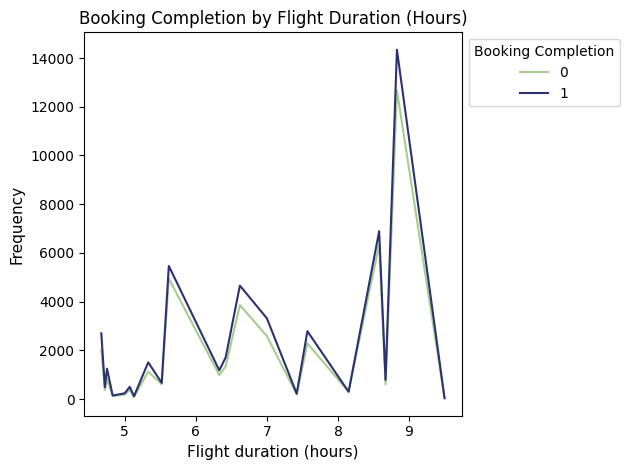

In [ ]:
df.groupby(['flight_duration', 'booking_complete']).size().unstack().plot(kind='line', colormap='crest', stacked=True);
plt.title('Booking Completion by Flight Duration (Hours)', fontsize = 12)
plt.xlabel('Flight duration (hours)', fontsize = 11)
plt.ylabel('Frequency', fontsize = 11)
plt.legend(title = 'Booking Completion', bbox_to_anchor=(1, 1), loc='upper left')
#plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

The plot shows flights with a duration between 4.67 and 9.5 hours. Flights tend to cluster around a duration of 8.83 hours, with completed and incomplete bookings following a similar pattern. This duration also represents the most frequent flight time overall.

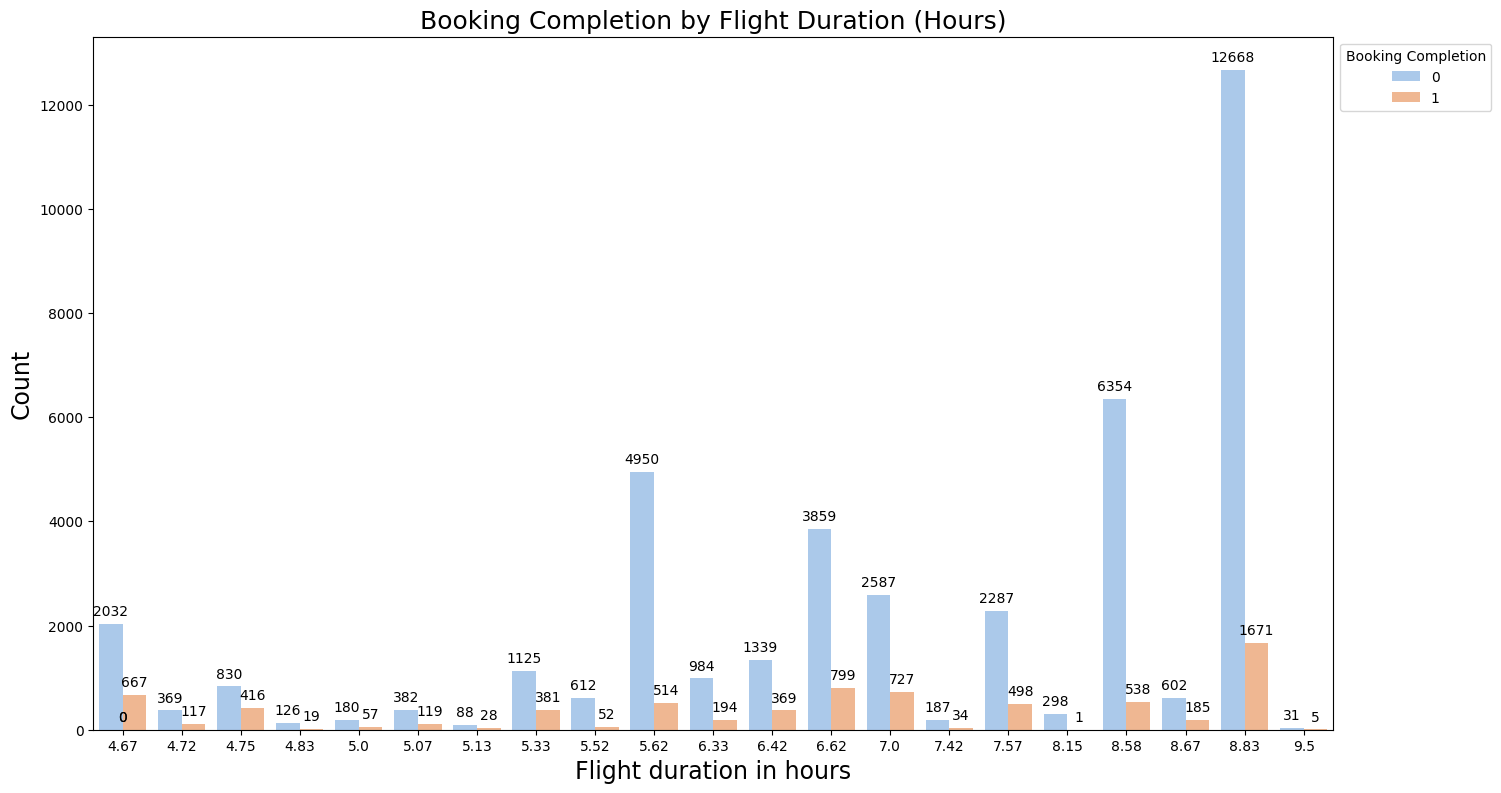

In [ ]:
plt.figure(figsize=(16,9))
splot = sns.countplot(data = df, x = 'flight_duration', hue = 'booking_complete_str', palette = 'pastel')
plt.title('Booking Completion by Flight Duration (Hours)', fontsize = 18)
plt.xlabel('Flight duration in hours', size = 17)
plt.ylabel('Count', size = 17)
plt.legend(title = 'Booking Completion', bbox_to_anchor=(1, 1), loc='upper left')
for p in splot.patches:
    splot.annotate(format(round(p.get_height())),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

plt.show()

In [ ]:
def flight_range(x):
    if 4.67 <= x < 6.28:
        return '4.67-6.27'
    elif  6.28 <= x < 7.89:
        return '6.28-7.88'
    elif 7.89 <= x <= 9.5:
        return '7.89-9.5'
    else:
        return 'Unknown'

df['flight_duration_str'] = df['flight_duration'].apply(flight_range)

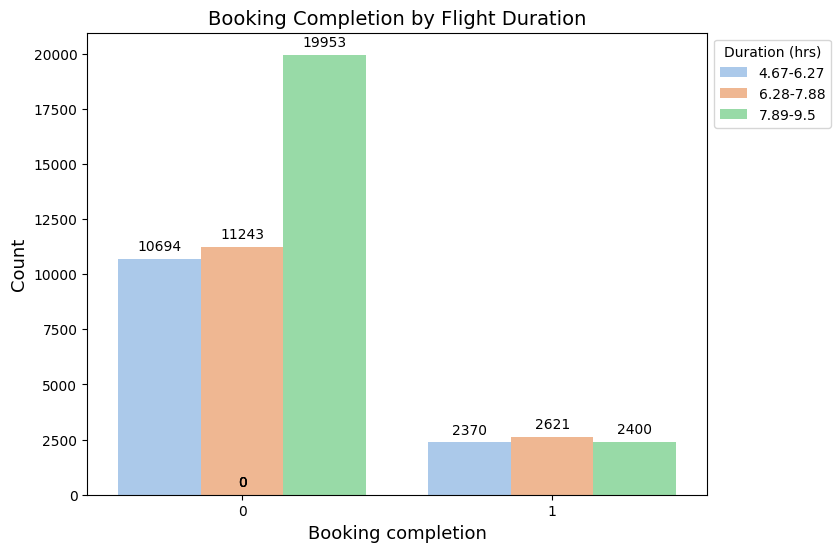

In [ ]:
plt.figure(figsize=(8,6))
splot = sns.countplot(data = df, x = 'booking_complete', hue = 'flight_duration_str', palette = 'pastel')
plt.title('Booking Completion by Flight Duration', fontsize = 14)
plt.xlabel('Booking completion', size = 13)
plt.ylabel('Count', size = 13)
plt.legend(title = 'Duration (hrs)', bbox_to_anchor=(1, 1), loc='upper left')
for p in splot.patches:
    splot.annotate(format(round(p.get_height())),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

plt.show()

linkcode
This graph compares booking completion rates (completed: 1, incomplete: 0) across three flight duration categories in hours.

For completed bookings, there was not a significant difference in flight duration preferences. However, customers abandoning bookings showed a preference for flights around 8.7 hours.

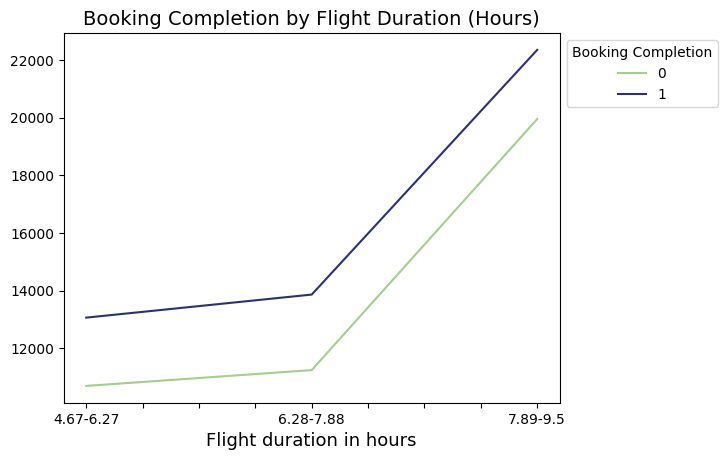

In [ ]:
df.groupby(['flight_duration_str', 'booking_complete']).size().unstack().plot(kind = 'line', colormap = 'crest', stacked = True);
plt.title('Booking Completion by Flight Duration (Hours)', fontsize = 14)
plt.xlabel('Flight duration in hours', fontsize = 13)
plt.legend(title = 'Booking Completion', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Flights lasting 8 or 9 hours were the most popular, while those averaging 6 hours were the least preferred.

Booking Completion vs. Continents

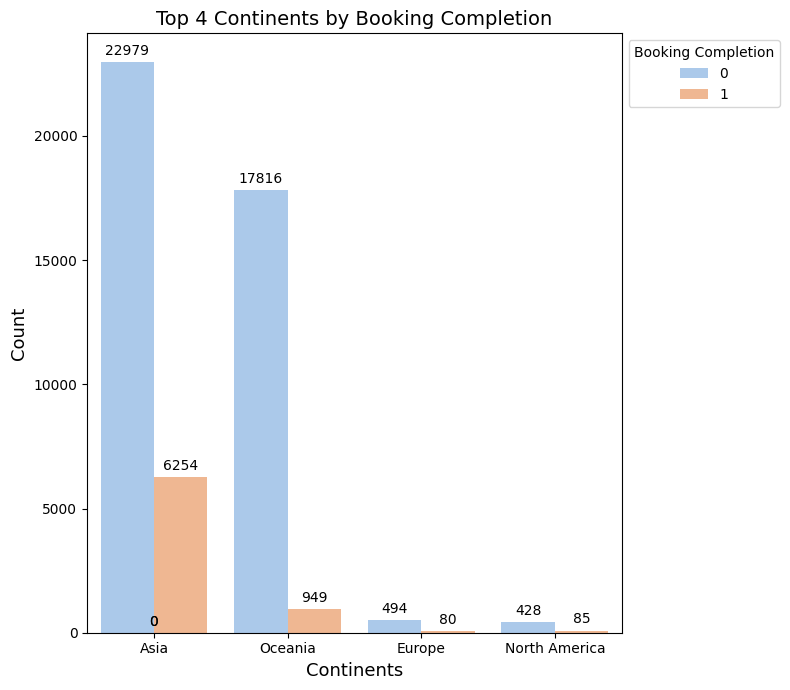

In [ ]:
top4 = df['booking_continent'].value_counts().sort_values(ascending=False).head(4)
booking_origin_top4 = df[df['booking_continent'].isin(top4.index)]
plt.figure(figsize = (8, 7))
plots = sns.countplot(data = booking_origin_top4, x = 'booking_continent', hue = 'booking_complete_str', palette = 'pastel', order = top4.index)
plt.title('Top 4 Continents by Booking Completion', fontsize = 14)
plt.xlabel('Continents', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.legend(title = 'Booking Completion', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()

Looking at booking completions, Asia leads the pack, followed by Oceania, North America, and Europe. For non-completed bookings, the order remains similar, with Asia on top, followed by Oceania, Europe, and North America.

Booking Completion vs. Number of Passengers

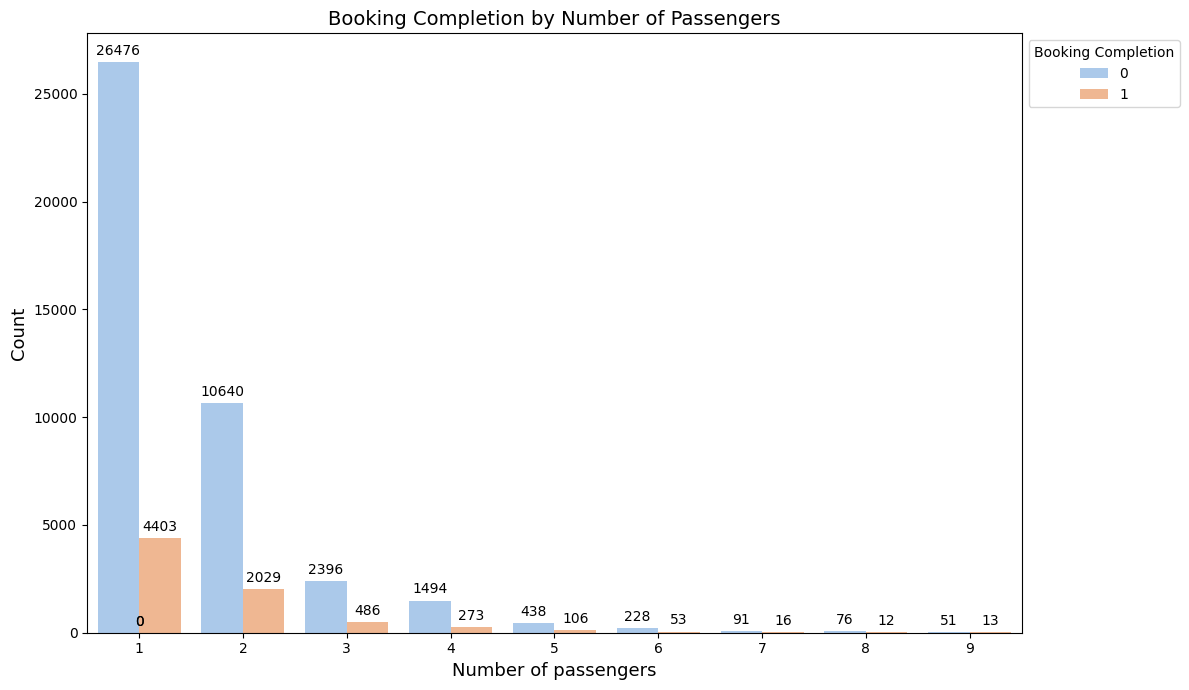

In [ ]:
plt.figure(figsize=(12,7))
plots = sns.countplot(data = df, x = 'num_passengers', hue = 'booking_complete_str', palette = 'pastel');
plt.title('Booking Completion by Number of Passengers', fontsize = 14)
plt.xlabel('Number of passengers', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.legend(title = 'Booking Completion', bbox_to_anchor = (1, 1), loc ='upper left')
plt.tight_layout()
for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()

The plot reveals an interesting trend: booking completions tend to decrease as the number of passengers per booking increases. For example, solo travelers have the highest volume of both completed and incomplete bookings. Conversely, bookings for groups of four or five have a significantly lower completion rate, and there are also fewer bookings for larger groups.

Booking Completion vs. Wants extra Baggage

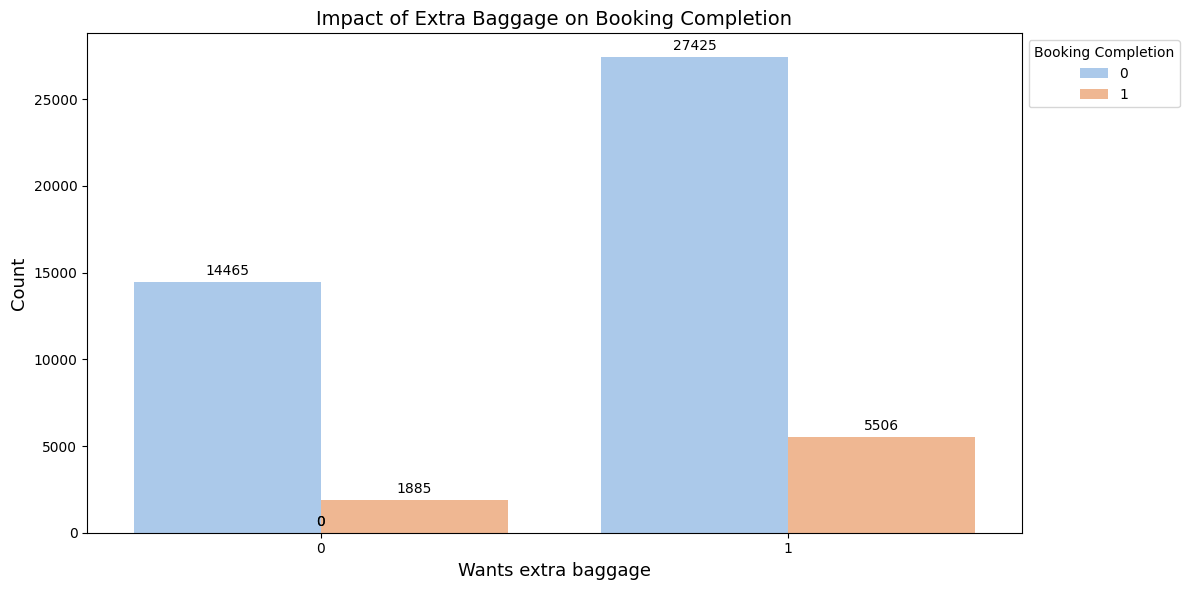

In [ ]:
plt.figure(figsize=(12,6))
plots = sns.countplot(data = df, x = 'wants_extra_baggage', hue = 'booking_complete_str', palette = 'pastel');
plt.title('Impact of Extra Baggage on Booking Completion', fontsize = 14)
plt.xlabel('Wants extra baggage', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.legend(title = 'Booking Completion', bbox_to_anchor = (1, 1), loc ='upper left')
plt.tight_layout()
for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()

The plot shows that passengers who want to add extra baggage have a higher booking completion rate compared to those who do not. The trend extends to incomplete bookings, where passengers are also less likely to want extra baggage.

Booking Completion vs. Wants Preferred Seat¶

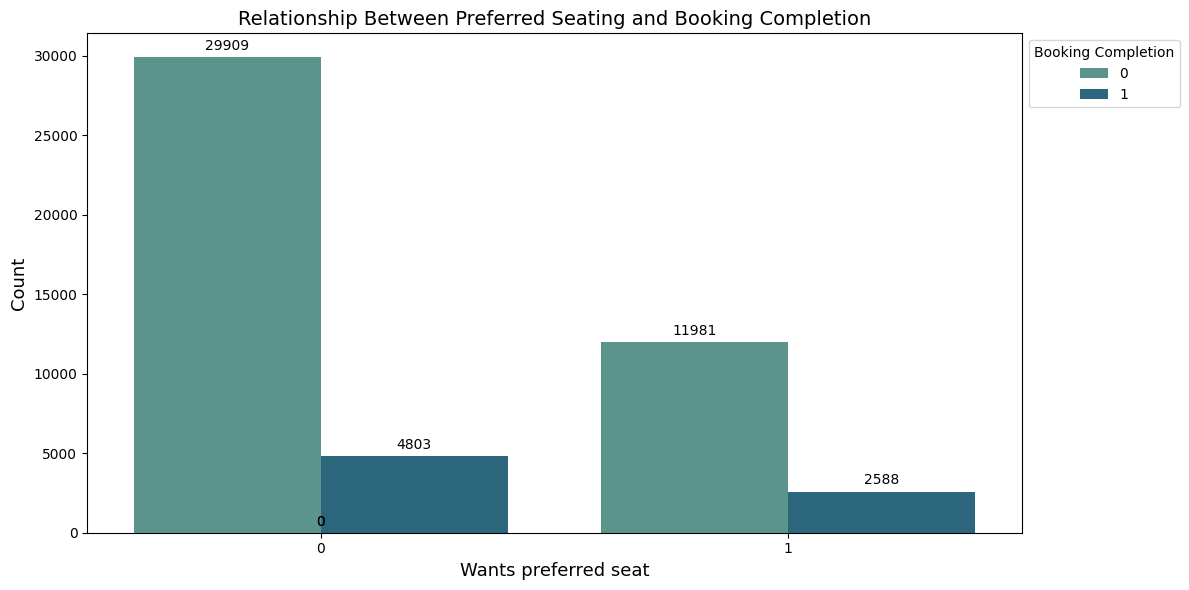

In [ ]:
plt.figure(figsize=(12,6))
plots = sns.countplot(data = df, x = 'wants_preferred_seat', hue = 'booking_complete_str', palette = 'crest');
plt.title('Relationship Between Preferred Seating and Booking Completion', fontsize = 14)
plt.xlabel('Wants preferred seat', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.legend(title = 'Booking Completion', bbox_to_anchor = (1, 1), loc ='upper left')
plt.tight_layout()
for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()

The analysis reveals that customers who do not select a preferred seat have a higher booking completion rate compared to those who do. This might sugge

Booking Completion vs. Wants in Flight Meals

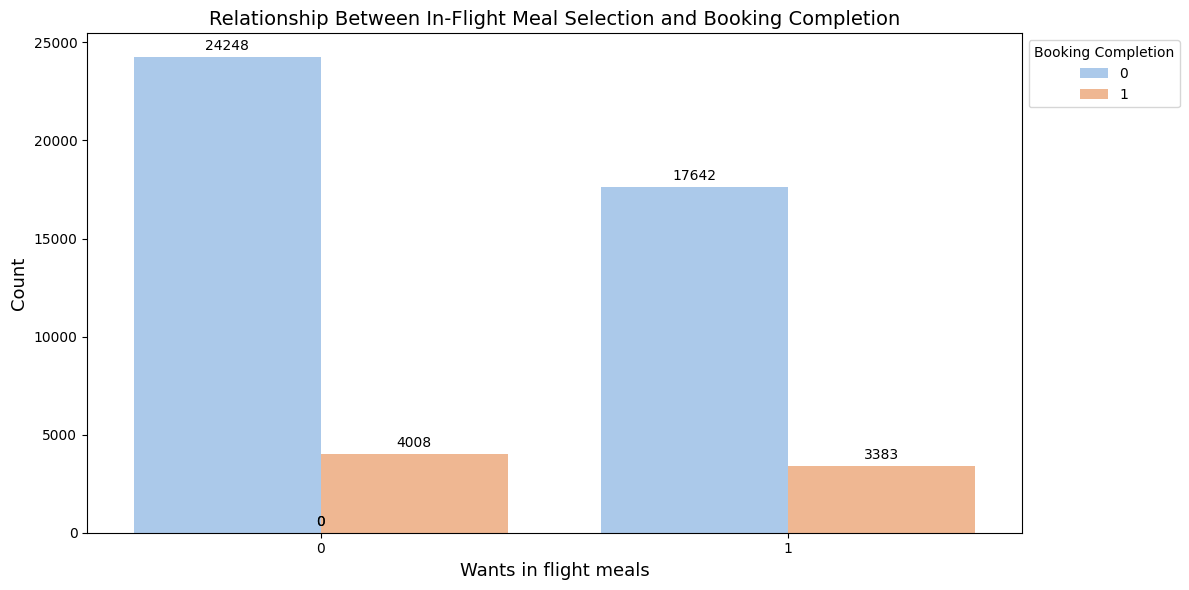

In [ ]:
plt.figure(figsize=(12,6))
plots = sns.countplot(data = df, x = 'wants_in_flight_meals', hue = 'booking_complete_str', palette = 'pastel');
plt.title('Relationship Between In-Flight Meal Selection and Booking Completion', fontsize = 14)
plt.xlabel('Wants in flight meals', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.legend(title = 'Booking Completion', bbox_to_anchor = (1, 1), loc ='upper left')
plt.tight_layout()
for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()

In [ ]:
df['wants_in_flight_meals_str'] = df['wants_in_flight_meals'].astype(str)

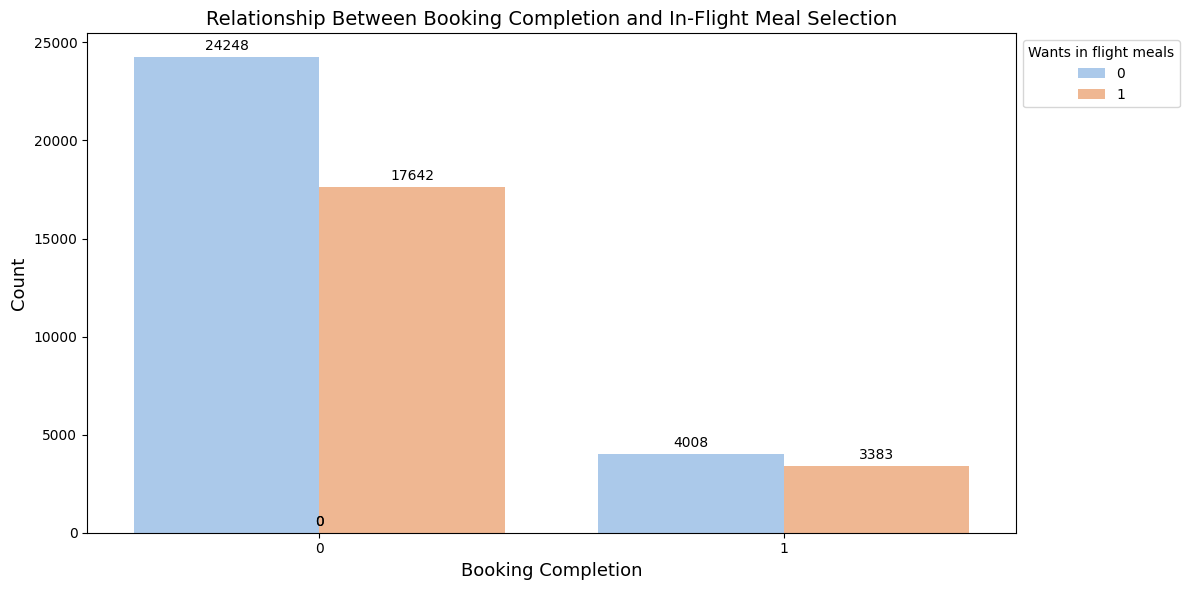

In [ ]:
plt.figure(figsize=(12,6))
plots = sns.countplot(data = df, x = 'booking_complete', hue = 'wants_in_flight_meals_str', palette = 'pastel');
plt.title('Relationship Between Booking Completion and In-Flight Meal Selection', fontsize = 14)
plt.xlabel('Booking Completion', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.legend(title = 'Wants in flight meals', bbox_to_anchor = (1, 1), loc ='upper left')
plt.tight_layout()
for bar in plots.patches:
    plots.annotate(format(round(bar.get_height())),(bar.get_x() + bar.get_width() / 2,bar.get_height()), ha = 'center', va = 'center', size = 10, xytext = (0, 8), textcoords = 'offset points')

plt.show()

The data shows an interesting trend between in-flight meals and booking completion. Customers who did not complete their bookings were more likely to skip selecting a meal altogether. However, even among those who finalised their bookings, a higher number (4008) opted out of in-flight meals compared to those who chose one (3383).



###Correlation among numeric variables¶

In [ ]:
num_var = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete']
corr = df[num_var].corr()
corr

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
num_passengers,1.000000,0.214999,-0.115380,0.016393,0.014801,0.120724,0.029509,0.022252,-0.062028,0.024092
purchase_lead,0.214999,1.000000,-0.076747,0.035112,0.036214,-0.021599,-0.004459,-0.022533,0.067934,-0.022132
length_of_stay,-0.115380,-0.076747,1.000000,-0.025525,0.000756,0.177536,0.031215,0.098846,0.140408,-0.042080
flight_hour,0.016393,0.035112,-0.025525,1.000000,0.024212,-0.010911,0.012251,0.011953,-0.003236,0.006705
flight_day,0.014801,0.036214,0.000756,0.024212,1.000000,-0.002517,0.005723,0.007799,0.019187,-0.007061
wants_extra_baggage,0.120724,-0.021599,0.177536,-0.010911,-0.002517,1.000000,0.208392,0.216835,0.057637,0.068452
wants_preferred_seat,0.029509,-0.004459,0.031215,0.012251,0.005723,0.208392,1.000000,0.315162,0.100652,0.050189
wants_in_flight_meals,0.022252,-0.022533,0.098846,0.011953,0.007799,0.216835,0.315162,1.000000,0.156233,0.026399
flight_duration,-0.062028,0.067934,0.140408,-0.003236,0.019187,0.057637,0.100652,0.156233,1.000000,-0.106529
booking_complete,0.024092,-0.022132,-0.042080,0.006705,-0.007061,0.068452,0.050189,0.026399,-0.106529,1.000000


The correlation matrix yielded valuable insights into how passenger choices relate to travel characteristics. Some of key findings were:

Passengers who opt for in-flight meals were more likely to also prefer selecting their seats beforehand (0.32). This suggests potential value in offering bundled deals or highlighting these options together during the booking process.

A weak but positive correlation exists between wanting in-flight meals and choosing extra baggage (0.22). This might indicate travellers planning longer trips or seeking a more comfortable experience often select both options.

Interestingly, a slight positive correlation emerged between the lead time for a purchase_lead and the number of passengers traveling together (0.21). This could suggest groups tend to plan trips further in advance compared to solo travelers.

It is important to note that the analysis revealed weak correlations between booking completion and the numerical features considered. This suggests booking completion is likely influenced by other factors. More features need to be added into the model and further investigation into these areas can provide a more comprehensive understanding of factors influencing booking completion.

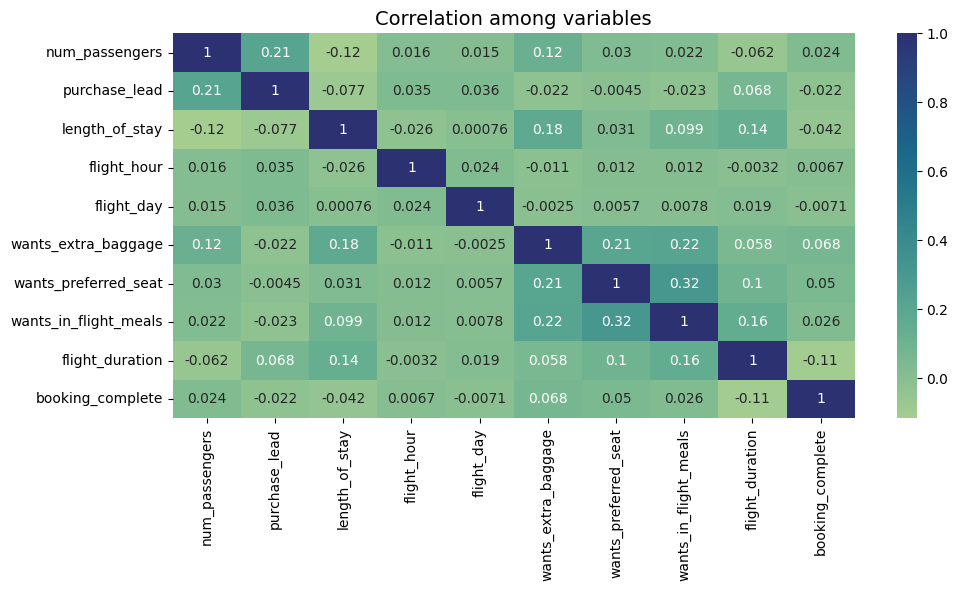

In [ ]:
# A heatmap
plt.figure(figsize=(11, 5))
sns.heatmap(corr, annot=True, cmap='crest')
plt.title('Correlation among variables', fontsize = 14)

plt.show()

#Model Building

Since the outcome variable 'booking_complete' is binary (0 or 1), meaning it predicts whether a booking is complete or not, a classification random forest is the better choice for this analysis. Random Forest, a supervised machine learning algorithm, is based on ensemble learning. The decision trees within a classification random forest make predictions by asking a series of questions about the features (e.g., 'number of passengers', 'purchase lead', etc.) that ultimately lead to a classification (booking complete or incomplete).

The dataset (21 features, 1 target variable, 49281 rows) is prepared for predictive modelling using a Random Forest Classifier from scikit-learn. Given that Random Forest models exhibit inherent robustness to outliers, we opted to include the 'purchase lead' and 'length of stay' variables in their raw state. Winsorisation, in this instance, did not yield substantial performance improvements. After training, the model's performance was evaluated with relevant metrics. Visualisations was also generated to understand the contribution of individual features.

##Splitting Data into Training and Testing Sets¶
The initial step involved distinguishing between the independent and dependent variables. The independent variable, typically denoted by X, is the one that potentially affects the dependent variable, represented by Y.

In [ ]:
X = df.drop(columns=['purchase_lead_winsorized', 'length_of_stay_winsorized',
                     'sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin',
                     'flight_hour_categ', 'flight_hour_categ_Afternoon', 'flight_hour_categ_Evening',
                     'flight_hour_categ_Morning', 'flight_hour_categ_Night', 'departures', 'arrivals',
                     'booking_continent', 'booking_complete_str', 'flight_duration_str', 'wants_in_flight_meals_str',
                     'booking_complete'], axis=1)

In [ ]:
X.shape

(49281, 20)

In [ ]:
y = df['booking_complete']
y.shape

(49281,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)

In [ ]:
y_train.value_counts()

,count
booking_complete,
0,33506
1,5918


##Class Balancing

###i) Random Undersampling

In [ ]:
# Randomly under sample the majority class
rus = RandomUnderSampler(sampling_strategy = 1)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


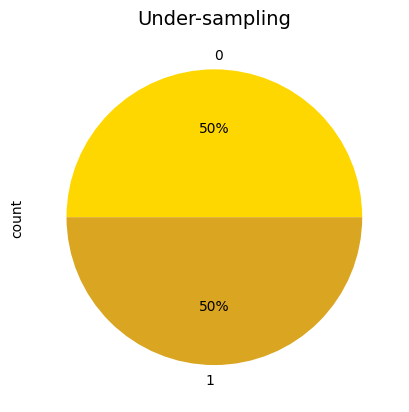

In [ ]:
ax = y_train_rus.value_counts().plot.pie(autopct = '%1.0f%%', colors=['#ffd700', '#daa520'])
_ = ax.set_title('Under-sampling', fontsize = 14)

In [ ]:
y_train_rus.value_counts()

,count
booking_complete,
0,5918
1,5918


In [ ]:
print(sorted(Counter(y_train_rus).items()))

[(0, 5918), (1, 5918)]


In [ ]:
y_train_rus.value_counts()

,count
booking_complete,
0,5918
1,5918


###ii) Random Oversampling

In [ ]:
ros = RandomOverSampler(sampling_strategy = 1)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


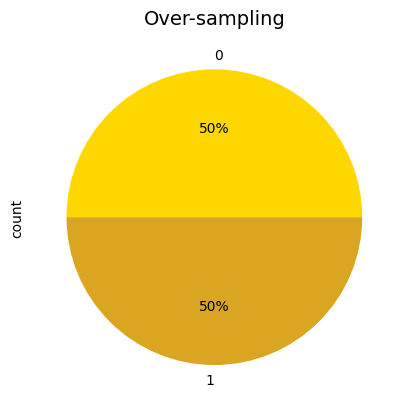

In [ ]:
ax = y_train_ros.value_counts().plot.pie(autopct = '%1.0f%%', colors=['#ffd700', '#daa520'])
_ = ax.set_title('Over-sampling', fontsize = 14)

In [ ]:
y_train_ros.value_counts()

,count
booking_complete,
0,33506
1,33506


###iii) Random Oversampling - SMOTE

In [ ]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state = 17)  # using imblearn to removing imablance in our dataset
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


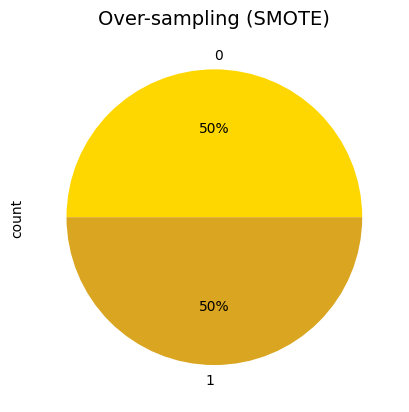

In [ ]:
ax = y_train_smote.value_counts().plot.pie(autopct = '%1.0f%%', colors=['#ffd700', '#daa520'])
_ = ax.set_title('Over-sampling (SMOTE)', fontsize = 14)

In [ ]:
y_train_smote.value_counts()

,count
booking_complete,
0,33506
1,33506


In [ ]:
print(sorted(Counter(y_train_smote).items()))

[(0, 33506), (1, 33506)]


###iv) Random Undersampling - NearMiss

In [ ]:
nearmiss = NearMiss(version = 3)
X_train_nearmiss, y_train_nearmiss = nearmiss.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The NearMiss or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


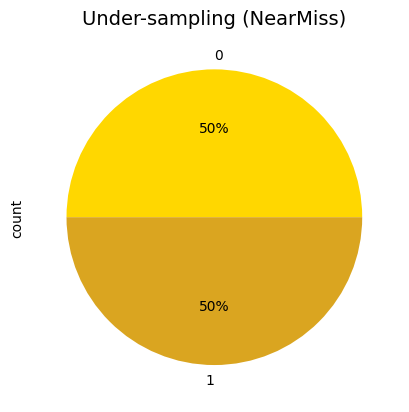

In [ ]:
ax = y_train_nearmiss.value_counts().plot.pie(autopct = '%1.0f%%', colors=['#ffd700', '#daa520'])
_ = ax.set_title('Under-sampling (NearMiss)', fontsize = 14)

In [ ]:
y_train_nearmiss.value_counts()

,count
booking_complete,
0,5918
1,5918


##Training the Baseline Model

In [ ]:
rf = RandomForestClassifier(random_state = 17).fit(X_train, y_train) # define model

In [ ]:
y_pred = rf.predict(X_test)  # predicting the testing set

In [ ]:
accuracy = accuracy_score(y_test, y_pred)  #  checking the predictions against the actual values in the test set
print('Accuracy:', accuracy)

Accuracy: 0.8402150755808055


#Model Evaluation

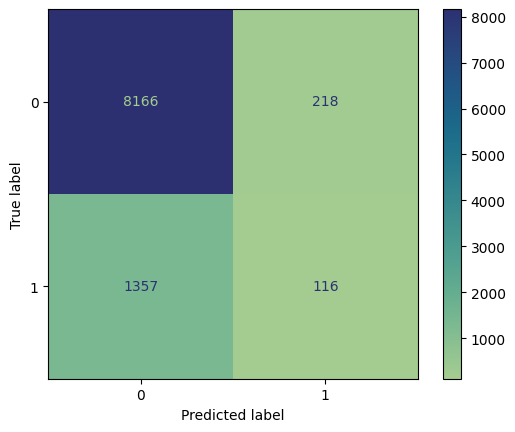

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='crest');

In [ ]:
print(confusion_matrix(y_test, y_pred))

[[8166  218]
 [1357  116]]


In [ ]:
accuracy = round(accuracy_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)

Accuracy: 0.84
Precision: 0.35
Recall: 0.08


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      8384
           1       0.35      0.08      0.13      1473

    accuracy                           0.84      9857
   macro avg       0.60      0.53      0.52      9857
weighted avg       0.78      0.84      0.79      9857



Classification results¶

The model classified our data into two classes: booking completed (represented by 1) and booking incomplete (represented by 0). Booking completed was the minority class, while incomplete booking was the majority class.

Precision is the proportion of positive predictions that are actually correct.

For class 0 ('booking incomplete'): 86% were classified correctly.
For class 1 ('booking completed'): Only 35% predicted classes were classified correctly.

Recall is the proportion of actual positive cases that are correctly identified by the model.

For class 0 ('booking incomplete'): 97% actual values were identified correctly.
For class 1 ('booking completed'): Only 8% actual instances were identified correctly.

F1-score combines precision and recall.

For class 0 ('booking incomplete'): 91% indicates a good performance of the model.
For class 1 ('booking completed'): 13% is a very low F-score, indicating poor performance.

The output shows that the minority class has a recall of 0.08, which means around 8% of the minority class is captured by the model and precision is 35%. Overall accuracy of the model is 84%. In other words, the model correctly classified 85% of all data points. However, this can be misleading due to the class imbalance. Imbalance means that the number of points for different classes in the dataset is different. As seen above, only 15% of customers finalised bookings for the airlines, while 85% did not.

##K-Fold Cross Validation¶

To be able to find the most fitting evaluation for a machine learning model, either K-Fold Cross Validation or Stratified K-Fold Cross Validation will be used. However, K-Fold Cross Validation is not suitable for handling imbalanced data because it randomly divides the data into k-folds. Folds might likely have negligible or no data from the minority class resulting in a highly biased model.

Instead, stratified and repeated stratified sampling is used, ensuring splitting the data randomly and keeping the same imbalanced class distribution for the baseline model. ROC AUC will be used to assess the overall performance of random forest classifier.

###Stratified K-Fold CV

In [ ]:
#skf = StratifiedKFold(n_splits = 10, random_state = 17)
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 17)
accuracy = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv = skf)
print('Mean ROC AUC: %.3f' % mean(accuracy))

Mean ROC AUC: 0.687


### Repeated Stratified K-Fold CV

In [ ]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 17) # evaluation procedure
scores = cross_val_score(rf, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1) # evaluate model
print('Mean ROC AUC: %.3f' % mean(scores)) # summarise performance

Mean ROC AUC: 0.688


The model achieved a mean ROC AUC of about 0.69.

#Comparison of Different Models

##a) Model building with undersampling balanced class

In [ ]:
rf1 = RandomForestClassifier(random_state = 17).fit(X_train_rus, y_train_rus) # Random Undersampling

In [ ]:
y_pred = rf1.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.61      0.74      8384
           1       0.24      0.69      0.35      1473

    accuracy                           0.63      9857
   macro avg       0.58      0.65      0.55      9857
weighted avg       0.82      0.63      0.68      9857



The model using undersample incresed recall from 0.08 to 0.69 and decreased precision from 0.35 to 0.24.

In [ ]:
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 17)
accuracy = cross_val_score(rf1, X_train_rus, y_train_rus, scoring='roc_auc', cv = skf)
print('Mean ROC AUC: %.3f' % mean(accuracy))

Mean ROC AUC: 0.702


In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=17)
scores = cross_val_score(rf1, X_train_rus, y_train_rus, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.702


##b) Model building with undersampling balanced class using NearMiss

In [ ]:
rf2 = RandomForestClassifier(random_state = 17).fit(X_train_nearmiss, y_train_nearmiss)

In [ ]:
y_pred = rf2.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.54      0.68      8384
           1       0.21      0.68      0.32      1473

    accuracy                           0.56      9857
   macro avg       0.56      0.61      0.50      9857
weighted avg       0.80      0.56      0.63      9857



Compared to the baseline model, our new model achieved a significant improvement in recall from 0.08 to 0.68. However, this came at the cost of a decrease in precision from 0.38 to 0.21.

In [ ]:
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 17)
accuracy = cross_val_score(rf2, X_train_nearmiss, y_train_nearmiss, scoring='roc_auc', cv = skf)
print('Mean ROC AUC: %.3f' % mean(accuracy))

Mean ROC AUC: 0.804


In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=17)
scores = cross_val_score(rf2, X_train_nearmiss, y_train_nearmiss, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.804


##c) Model building with oversampling balanced class

In [ ]:
rf3 = RandomForestClassifier(random_state = 17).fit(X_train_ros, y_train_ros)

In [ ]:
y_pred = rf3.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      8384
           1       0.28      0.17      0.21      1473

    accuracy                           0.81      9857
   macro avg       0.57      0.55      0.55      9857
weighted avg       0.78      0.81      0.79      9857



linkcode
The output shows that random oversampling did not provide a better result. The recall and F1 score increased and the precision decreased.

In [ ]:
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 17)
accuracy = cross_val_score(rf3, X_train_ros, y_train_ros, scoring = 'roc_auc', cv = skf)
print('Mean ROC AUC: %.3f' % mean(accuracy))

Mean ROC AUC: 0.998


In [ ]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 17)
scores = cross_val_score(rf3, X_train_ros, y_train_ros, scoring = 'roc_auc', cv = cv, n_jobs = -1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.998


##d) Model building with oversampling balanced class using SMOTE¶

In [ ]:
rf4 = RandomForestClassifier(random_state = 17).fit(X_train_smote, y_train_smote)

In [ ]:
y_pred = rf4.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      8384
           1       0.25      0.21      0.23      1473

    accuracy                           0.79      9857
   macro avg       0.56      0.55      0.55      9857
weighted avg       0.77      0.79      0.78      9857



The model using SMOTE increased recall from 0.08 to 0.21 and it improved the model's ability to capture the minority class, while the precision decreased from 0.38 to 0.25.

In [ ]:
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 17)
accuracy = cross_val_score(rf4, X_train_smote, y_train_smote, scoring = 'roc_auc', cv = skf)
print('Mean ROC AUC: %.3f' % mean(accuracy))

Mean ROC AUC: 0.947


In [ ]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 17)
scores = cross_val_score(rf4, X_train_smote, y_train_smote, scoring = 'roc_auc', cv = cv, n_jobs = -1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.947


##e) Model building with Class weight balancing

In [ ]:
rf5 = RandomForestClassifier(random_state = 17, class_weight = 'balanced').fit(X_train, y_train)

In [ ]:
y_pred = rf5.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      8384
           1       0.35      0.07      0.12      1473

    accuracy                           0.84      9857
   macro avg       0.61      0.52      0.52      9857
weighted avg       0.78      0.84      0.79      9857



In [ ]:
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 17)
accuracy = cross_val_score(rf5, X_train, y_train, scoring = 'roc_auc', cv = skf)
print('Mean ROC AUC: %.3f' % mean(accuracy))

Mean ROC AUC: 0.687


In [ ]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 17)
scores = cross_val_score(rf5, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.686


Comparing performance of different models¶

The class-weighted model performed similarly to the baseline model.
The highest recall of about 0.70 was for the two undersampling models.
Oversampling techniques significantly improved model performance. The SMOTE oversampling model achieved a mean ROC AUC of 0.95, while the model with balanced class oversampling reached a mean ROC AUC of 0.99 compared to the baseline model of 0.70.
NearMiss undersampling (recall: 70%, precision: 21%, ROC AUC: 81.6%) improved upon the baseline model.
These findings suggests that the model could benefit from further improvement.

#Feature Importance Analysis¶
The baseline model is involved in our feature selection process.

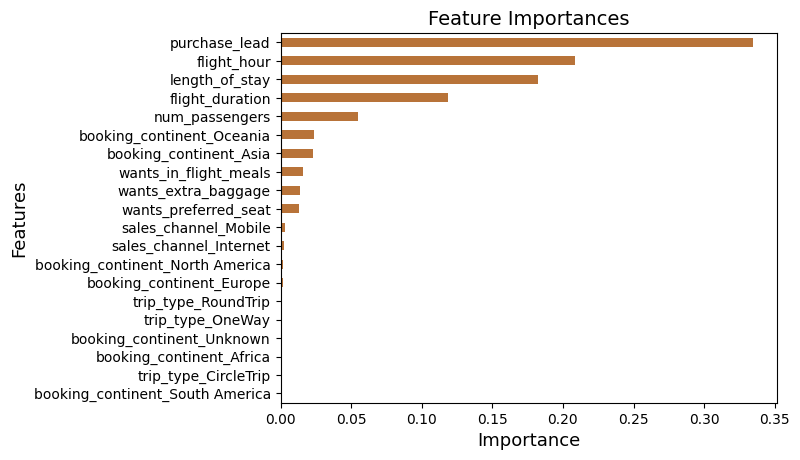

In [ ]:
#feature_importances = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = False).head(11)
feature_importances = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = True)

feature_importances.plot.barh(color = '#b87339')
plt.title('Feature Importances', fontsize = 14)
plt.xlabel('Importance', fontsize = 13)
plt.ylabel('Features', fontsize = 13)
plt.show()

In [ ]:
feature_importances.sort_values(ascending = False)

,0
purchase_lead,0.334564
flight_hour,0.208418
length_of_stay,0.182028
flight_duration,0.118511
num_passengers,0.054757
booking_continent_Oceania,0.023455
booking_continent_Asia,0.022758
wants_in_flight_meals,0.015733
wants_extra_baggage,0.014095
wants_preferred_seat,0.013160


#Conclusion

This analysis delved into the factors influencing the model's predictions for booking outcomes, which is crucial for airlines. Importantly, 'purchase_lead', the time difference between a booking's purchase and the departure date, emerged as the most significant variable. This finding suggests that bookings made closer to the departure date might have a stronger influence on the model's predictions compared to other factors we considered. Based on these findings, airlines can prioritise strategies to influence bookings made closer to departure. This could involve targeted marketing campaigns or dynamic pricing adjustments.

While purchase lead proved to be the most critical factor, other flight related features also played a significant role in the model. Flight hour, capturing the departure time, flight duration, representing the total travel time, and length of stay, indicating the trip duration, were all identified as important features. Interestingly, the customer's booking origin, sales channel, and trip type were not found to be as important as other factors. This finding suggests that factors like travel window ('purchase-lead') might be more influential than initial assumptions about traveler demographics or trip purposes.

However, more features such as transparency, promotions, price comparison tools to name a few should be incorporated into the model for future investigation. Additionally, while the focus of this analysis was on booking outcomes, further investigation into cancellation predictions could be valuable. It is important to acknowledge that this analysis was based on a specific dataset and might not be generalisable to all airlines or market conditions. Future research with a broader dataset and external validation can strengthen these findings. By identifying the key factors influencing booking outcomes, this analysis provides valuable insights for airlines to improve their model performance and ultimately optimize their booking strategies.

